# A Deep Learning Heteroscedastic Uncertainty Approach to Fault Detection of Wind Turbines using SCADA data 

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow.keras as keras
import scipy.stats as stats
import math
from rate import *

from sklearn.datasets import make_friedman2
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic, ExpSineSquared
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from math import sqrt

from tensorflow.keras.layers import TimeDistributed, Attention, Input, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, BatchNormalization, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#### Auxiliary Functions

In [2]:
def plot_means_variances(y_true, y_means, y_stddevs):
    plt.rc('font', size=14)
    min_vals = np.min([np.min(y_true), np.min(y_means)])
    max_vals = np.max([np.max(y_true), np.max(y_means)])

    plt.figure(figsize=(16, 6))

    # Plot predicted vs true
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_means, alpha = .7, color="0.3", linewidth = 0, s = 2)
    plt.plot([min_vals, max_vals], [min_vals, max_vals], 'k--', color='red')  # Add diagonal line
    plt.title('Fig (a): Predicted vs True Values')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    
    def plot_binned_residuals(y_true, residuals, num_bins=20):
        bins = np.linspace(min(y_true), max(y_true), num_bins + 1)

        bin_means = [0]*num_bins
        bin_stddevs = [0]*num_bins

        for i in range(num_bins):
            mask = (y_true >= bins[i]) & (y_true < bins[i + 1])
            if np.any(mask):
                bin_means[i] = np.mean(y_true[mask])
                bin_stddevs[i] = np.sqrt(mean_squared_error(y_means[mask], y_true[mask]))
        return bin_means, bin_stddevs

    bin_means, bin_stddevs = plot_binned_residuals(y_true, y_means, num_bins=20)
    
    # Plot residuals vs true
    plt.subplot(1, 2, 2)
    plt.scatter(y_true, y_stddevs, alpha = .7, color="0.3", linewidth = 0, s = 2, label='Predicted Standard Deviation', zorder=1)
    plt.scatter(bin_means, bin_stddevs, alpha=1, s=50, color='red', label='True Binned Root Mean Squared Error', zorder=2)
    plt.title('Fig (b): Predicted Standard Deviation vs True RMSE')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Standard Deviation')
    plt.legend()


    plt.tight_layout()
    plt.show()

    
def evaluate_and_print_metrics(results, model_name, y_train, y_test, y_train_pred, y_test_pred, y_train_stddevs, y_test_stddevs, ci):
    z_value = stats.norm.ppf((1 + ci) / 2)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_mae = mean_absolute_error(y_train, y_train_pred)    # in %
    test_mae = mean_absolute_error(y_test, y_test_pred)       # in %

    train_lower_bound = y_train_pred - z_value * y_train_stddevs
    train_upper_bound = y_train_pred + z_value * y_train_stddevs

    test_lower_bound = y_test_pred - z_value * y_test_stddevs
    test_upper_bound = y_test_pred + z_value * y_test_stddevs

    train_within_interval = np.sum(np.logical_and(y_train.ravel() >= train_lower_bound, y_train.ravel() <= train_upper_bound))
    test_within_interval = np.sum(np.logical_and(y_test.ravel() >= test_lower_bound, y_test.ravel() <= test_upper_bound))

    train_percentage_within_interval = (train_within_interval / len(y_train.ravel())) * 100
    test_percentage_within_interval = (test_within_interval / len(y_test.ravel())) * 100

   
    results[model_name] = {
        "Test Root Mean Squared Error (RMSE): ": test_rmse,
        "Test Mean Absolute Error (MAE): ": test_mae,
        f"Percentage of Test Data Points within {ci:.2f}% CI: ": test_percentage_within_interval
    }

    print(f"Train RMSE: {train_rmse:.3f}")
    print(f"Test RMSE: {test_rmse:.3f}")
    print(f"Train MAE: {train_mae:.3f}")
    print(f"Test MAE: {test_mae:.3f}")
    print(f"Percentage of Train Data Points within {ci*100:.2f}% CI: {train_percentage_within_interval:.2f}%")
    print(f"Percentage of Test Data Points within {ci*100:.2f}% CI: {test_percentage_within_interval:.2f}%")

In [3]:
def plot_confidence_interval_histogram(y_test_pred, y_test_std, y_test, bins=20):
    plt.rc('font', size=14)
    
    # Compute the t-values of the confidence intervals based on Z-scores
    t_values = np.array([norm.ppf(i/bins + (1-i/bins)/2) for i in range(1, bins+1)])

    percentages_within_interval = []
    for t_value in t_values:
        lower_bounds = y_test_pred.ravel() - t_value * y_test_std
        upper_bounds = y_test_pred.ravel() + t_value * y_test_std

        # Count number of data points within the confidence interval
        is_within_interval = np.logical_and(y_test >= lower_bounds, y_test <= upper_bounds)
        num_within_interval = np.sum(is_within_interval)

        # Calculate the percentage of data points within the confidence interval
        percentage_within_interval = (num_within_interval / len(y_test)) * 100
        percentages_within_interval.append(percentage_within_interval)

    plt.figure(figsize=(16, 6))
    bars = plt.bar(np.arange(1, bins+1), percentages_within_interval, color='lightgray', edgecolor='black')
    plt.xlabel('Confidence Intervals')
    plt.ylabel('Percentage within Interval')
    plt.title('Percentage of Data Points within Confidence Intervals')

    # Add numbers on top of interval bar
    for bar, percentage in zip(bars, percentages_within_interval):
        plt.text(bar.get_x() + bar.get_width() / 8,
             bar.get_height() + 1,
             f'{percentage:.1f}%', 
             fontsize=9)

    plt.xticks(np.arange(1, bins+1), [f'{i/bins*100:.0f}%' for i in range(1, bins+1)])
    plt.savefig("bar2.png", bbox_inches='tight')
    plt.show()

In [4]:
def train_model(model, X_train, y_train, patience, epochs, batch_size, cp_callback):
    tf.random.set_seed(MODELS_SEED)
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    model.summary()
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.1, callbacks=[early_stopping, cp_callback])
    return history

## Data Analysis

In [5]:
# In order to ensure that each model has repeatable results,we fix the seed both for the
# data splitting part and for the initilialization of the networks' weights. Theoretially
# speaking, we should average over different seeds to ensure the robustness of our results.
# However, in practice, due to the size of the data set this is unfeasibile and we only do
# this for the best performing model to show that the variability of results based on seed
# is almost none.

keras.utils.set_random_seed(812)
MODELS_SEED = 42

In [6]:
file_path = 'Cleaned_data.pkl'
df_full = pd.read_pickle(file_path)

In [7]:
# Datetime column
DATETIME_COL = 'Date.time'

# Features considered
features = [
'Wind.speed.me',
'Wind.speed.sd',
'Wind.speed.min',
'Wind.speed.max',
'Front.bearing.temp.me',
'Front.bearing.temp.sd',
'Front.bearing.temp.min',
'Front.bearing.temp.max',
'Rear.bearing.temp.me',
'Rear.bearing.temp.sd',
'Rear.bearing.temp.min',
'Rear.bearing.temp.max',
'Rotor.bearing.temp.me',
'Stator1.temp.me',
'Nacelle.ambient.temp.me',
'Nacelle.temp.me',
'Transformer.temp.me',
'Gear.oil.temp.me',
'Gear.oil.temp.me.1',
'Top.box.temp.me',
'Hub.temp.me',
'Conv.Amb.temp.me',
'Rotor.bearing.temp.me',
'Transformer.cell.temp.me',
'Motor.axis1.temp.me',
'Motor.axis2.temp.me',
'CPU.temp.me',
'Blade.ang.pitch.pos.A.me',
'Blade.ang.pitch.pos.B.me',
'Blade.ang.pitch.pos.C.me',
'Gear.oil.inlet.press.me',
'Gear.oil.pump.press.me',
'Drive.train.acceleration.me',
'Tower.Acceleration.x',
'Tower.Acceleration.y'
]

output_feature = 'Power.me'

# Only consider the turbine with ID 5
TURBINE_ID = 5
df = df_full[df_full['turbine'] == TURBINE_ID]
print(f"Total data points for turbine {TURBINE_ID} before removing NaNs: ", len(df))
df = df.dropna(subset=features + [output_feature] + [DATETIME_COL])
print(f"Total data points for turbine {TURBINE_ID} after removing NaNs: ", len(df))
df = df.reset_index(drop=False) 

Total data points for turbine 5 before removing NaNs:  191579
Total data points for turbine 5 after removing NaNs:  189381


In [8]:
df.head()

index           Date.time    Power.me   Power.sd   Power.min   Power.max  \
0  778652 2017-09-25 00:00:00  170.785782  18.711275  117.633080  201.376236   
1  778653 2017-09-25 00:10:00  196.361282  29.352943  132.657440  244.603409   
2  778654 2017-09-25 00:20:00  213.066101  18.548962  175.467987  244.880829   
3  778655 2017-09-25 00:30:00  180.647583  16.838543  143.989594  220.636795   
4  778656 2017-09-25 00:40:00  201.553589  11.615179  178.872192  223.635696   

   Pot.Power.me  Wind.speed.me  Wind.speed.sd  Wind.speed.min  ...  \
0    178.246281       4.758976       0.470051        3.839334  ...   
1    214.993427       5.053728       0.455439        4.297034  ...   
2    186.659122       4.834767       0.438846        3.727230  ...   
3    194.940699       4.909376       0.403833        3.910666  ...   
4    182.866606       4.800600       0.485835        4.098299  ...   

   Blade.ang.pitch.pos.C.sd  Blade.ang.pitch.pos.C.min  \
0                       NaN                        NaN   
1                       NaN                        NaN   
2                       NaN                        NaN   
3                       NaN                        NaN   
4                       NaN                        NaN   

   Blade.ang.pitch.pos.C.max  Gear.oil.inlet.press.me  Gear.oil.pump.press.me  \
0                        NaN                76.154892              329.839172   
1                        NaN                78.530861              337.024353   
2                        NaN                78.428474              335.595490   
3                        NaN                72.759590              318.466614   
4                        NaN                73.908447              320.857849   

   Drive.train.acceleration.me  Tower.Acceleration.x  Tower.Acceleration.y  \
0                    47.446136             34.605957             12.856477   
1                    45.788548             24.391794             12.387291   
2                    44.958530             19.414160             14.047290   
3                    45.136253             21.682341             11.815598   
4                    44.799519             21.100346             11.945602   

   turbine  year  
0        5  2017  
1        5  2017  
2        5  2017  
3        5  2017  
4        5  2017  

[5 rows x 111 columns]

In [9]:
descriptive_stats = df[features + [output_feature]].describe()
pd.set_option('display.max_columns', None)
display(descriptive_stats)

Wind.speed.me  Wind.speed.sd  Wind.speed.min  Wind.speed.max  \
count  189381.000000  189381.000000   189381.000000   189381.000000   
mean        6.061792       0.929598        4.285672        7.826800   
std         2.767883       0.461186        2.206099        3.482993   
min         0.129863       0.000000       -0.444250        0.243750   
25%         4.052706       0.595049        2.674919        5.362026   
50%         5.707567       0.851638        4.071932        7.317771   
75%         7.657582       1.180467        5.618109        9.794380   
max        22.151195       5.016237       17.995665       32.264656   

       Front.bearing.temp.me  Front.bearing.temp.sd  Front.bearing.temp.min  \
count          189381.000000          189381.000000           189381.000000   
mean               65.249559               0.611390               64.235198   
std                10.096854               0.504141                9.916454   
min                14.565001               0.000000               14.400000   
25%                61.002500               0.236114               60.099998   
50%                69.794736               0.475730               68.449997   
75%                72.277500               0.845470               71.199997   
max                81.182500               7.816919               80.800003   

       Front.bearing.temp.max  Rear.bearing.temp.me  Rear.bearing.temp.sd  \
count           189381.000000         189381.000000         189381.000000   
mean                66.234087             63.228148              0.665511   
std                 10.287366              8.592414              0.576825   
min                 14.600000             13.147500              0.000000   
25%                 61.900002             61.092499              0.240885   
50%                 70.900002             66.140001              0.477723   
75%                 73.300003             68.575001              0.928453   
max                 81.449997             75.092500              7.473754   

       Rear.bearing.temp.min  Rear.bearing.temp.max  Rotor.bearing.temp.me  \
count          189381.000000          189381.000000          189381.000000   
mean               62.131779              64.294001              25.147016   
std                 8.409253               8.819052               3.963058   
min                13.100000              13.200000               9.002500   
25%                60.400002              61.849998              22.215000   
50%                65.050003              67.000000              25.049999   
75%                67.199997              70.000000              28.059524   
max                74.649994              76.400002              39.097499   

       Stator1.temp.me  Nacelle.ambient.temp.me  Nacelle.temp.me  \
count    189381.000000            189381.000000    189381.000000   
mean         62.680004                10.395775        19.545742   
std           7.853748                 5.895684         5.386682   
min          13.720000                -6.800000         1.245000   
25%          59.665001                 6.020000        15.917500   
50%          62.027500                 9.690000        19.530000   
75%          64.492499                14.352500        23.075000   
max         103.014999                35.225000        39.430000   

       Transformer.temp.me  Gear.oil.temp.me  Gear.oil.temp.me.1  \
count        189381.000000     189381.000000       189381.000000   
mean             48.827492         48.283892           52.035799   
std              19.850288          8.085823            5.862262   
min              18.690001          9.235000           13.857500   
25%              35.562500         42.110000           49.326313   
50%              42.087499         50.200000           53.122500   
75%              54.002631         55.132500           56.322498   
max             107.987503         60.208335           59.926316   

       Top.box.temp.me    Hub.te

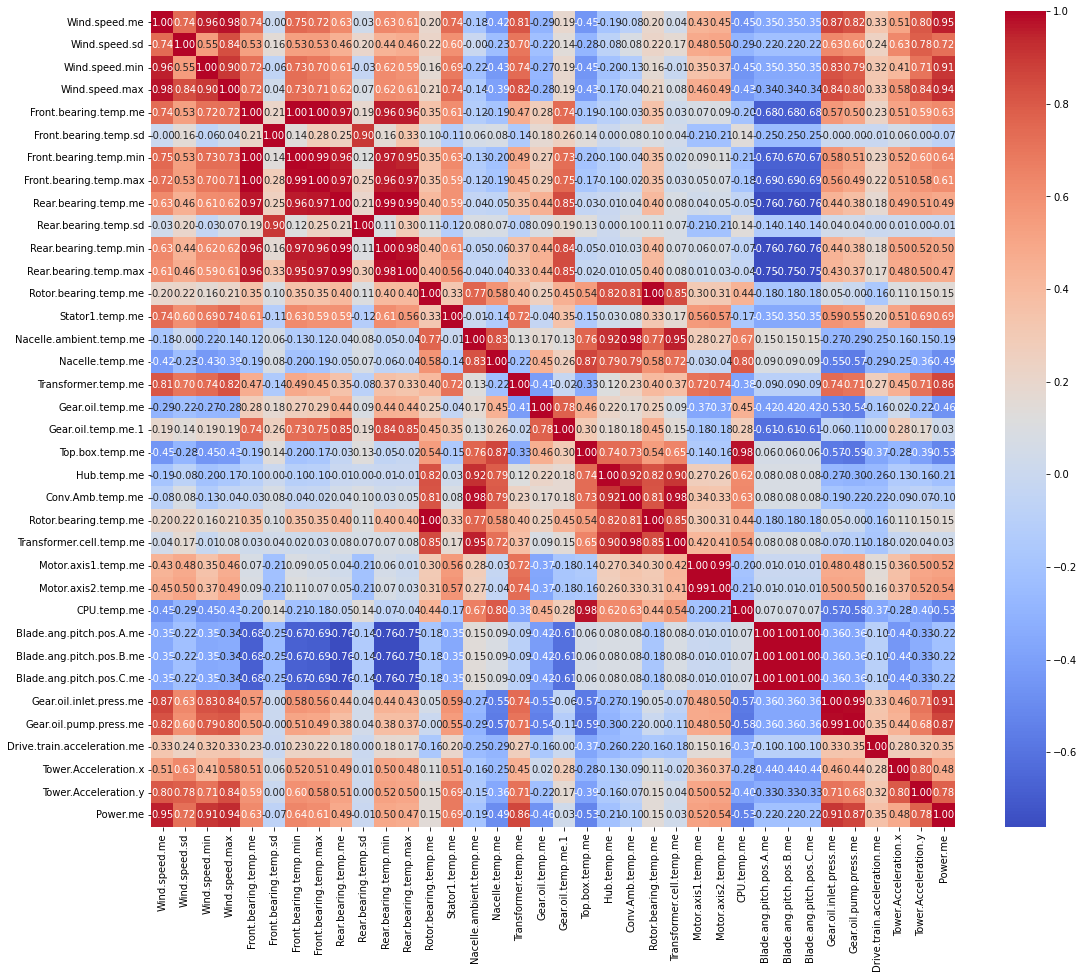

In [20]:
plt.figure(figsize=(18, 15))
correlation_matrix = df[features + [output_feature]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

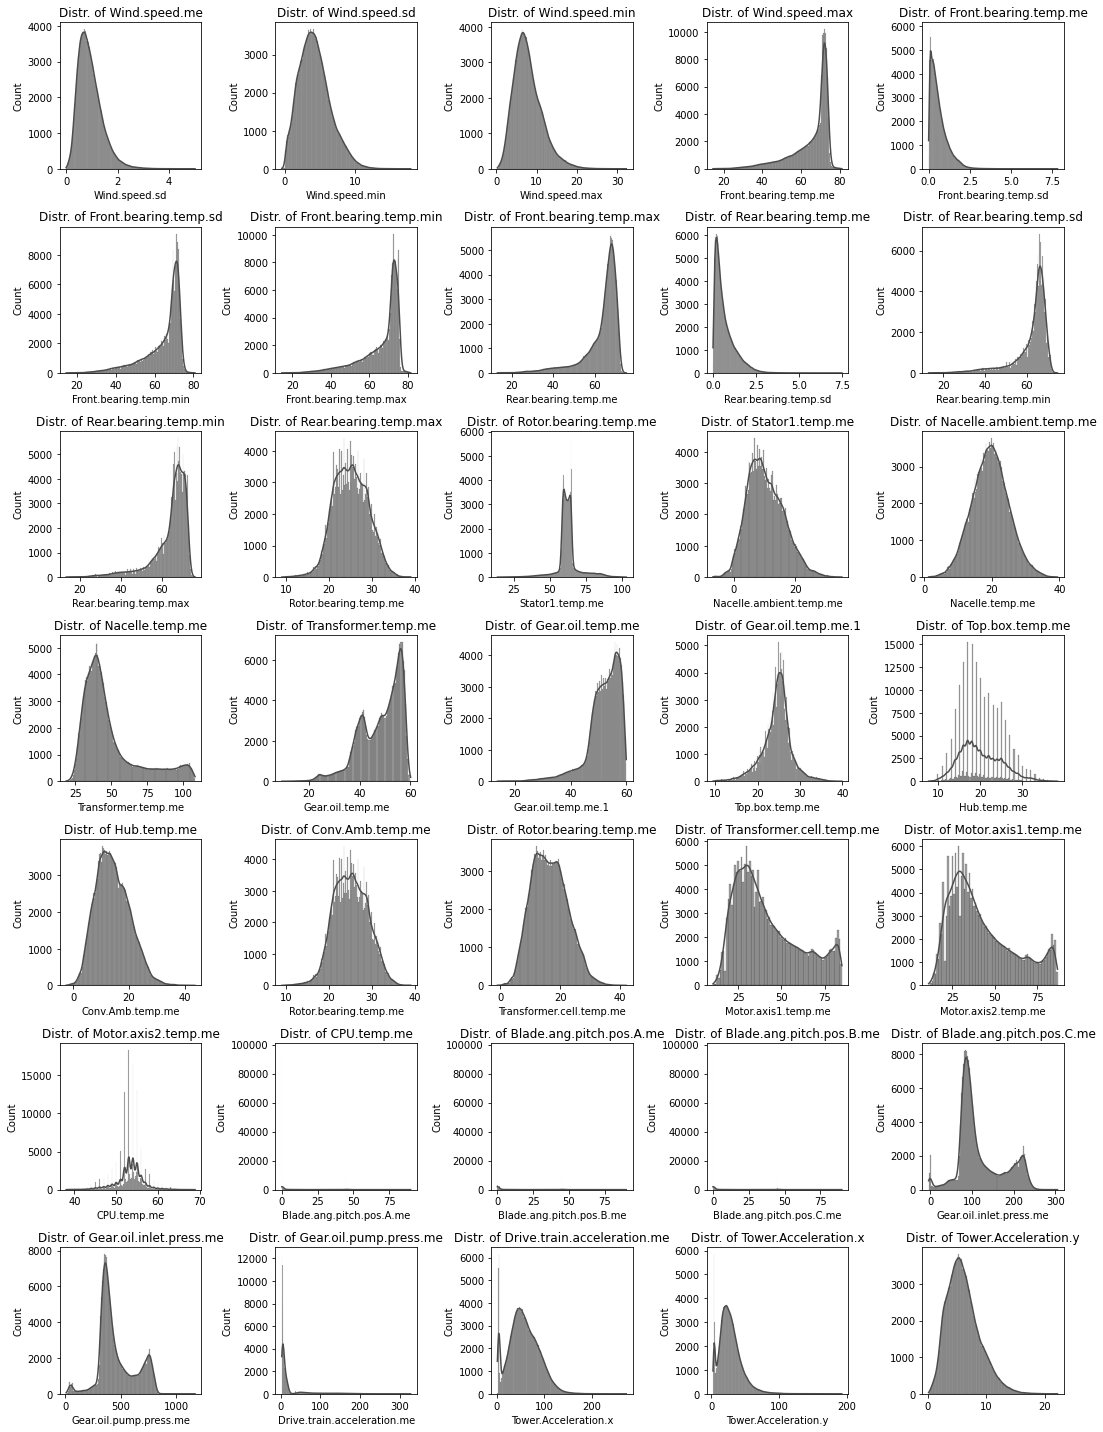

In [21]:
num_cols = 5
num_rows = math.ceil(len(features) // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(df[feature], kde=True, ax=axes[i-1], color="0.3")
    axes[i].set_title(f'Distr. of {feature}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')


plt.tight_layout()
plt.show()

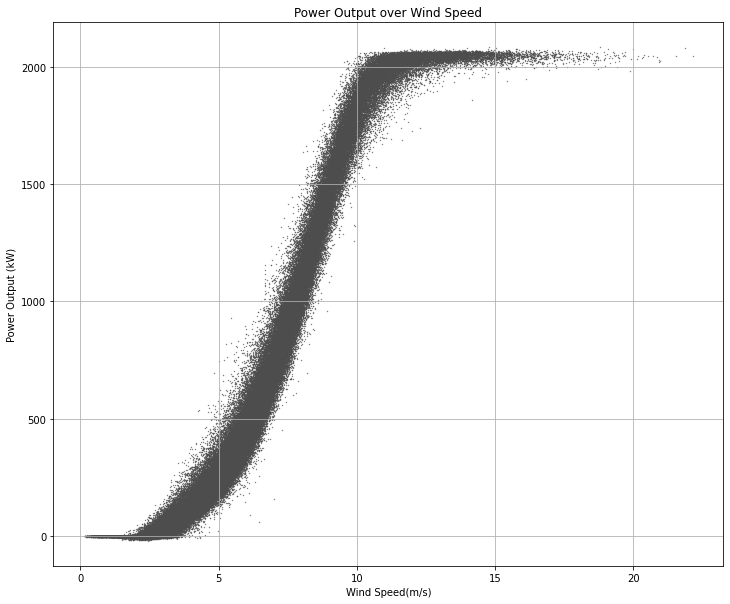

In [22]:
# Plot Power over Wind Speed
plt.figure(figsize=(12, 10))
plt.scatter(df['Wind.speed.me'], df[output_feature], alpha = .7, color="0.3", linewidth = 0, s = 2)
plt.title('Power Output over Wind Speed')
plt.xlabel('Wind Speed(m/s)')
plt.ylabel('Power Output (kW)')
plt.grid(True)
plt.show()

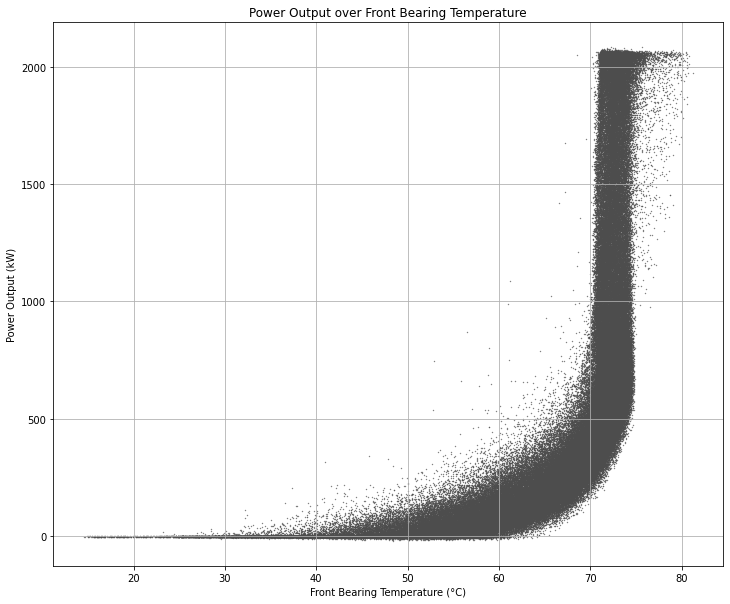

In [23]:
# Plot Power over Front Bearing Temperature
plt.figure(figsize=(12, 10))
plt.scatter(df['Front.bearing.temp.me'], df[output_feature], alpha = .7, color="0.3", linewidth = 0, s = 2)
plt.title('Power Output over Front Bearing Temperature')
plt.xlabel('Front Bearing Temperature (°C)')
plt.ylabel('Power Output (kW)')
plt.grid(True)
plt.show()

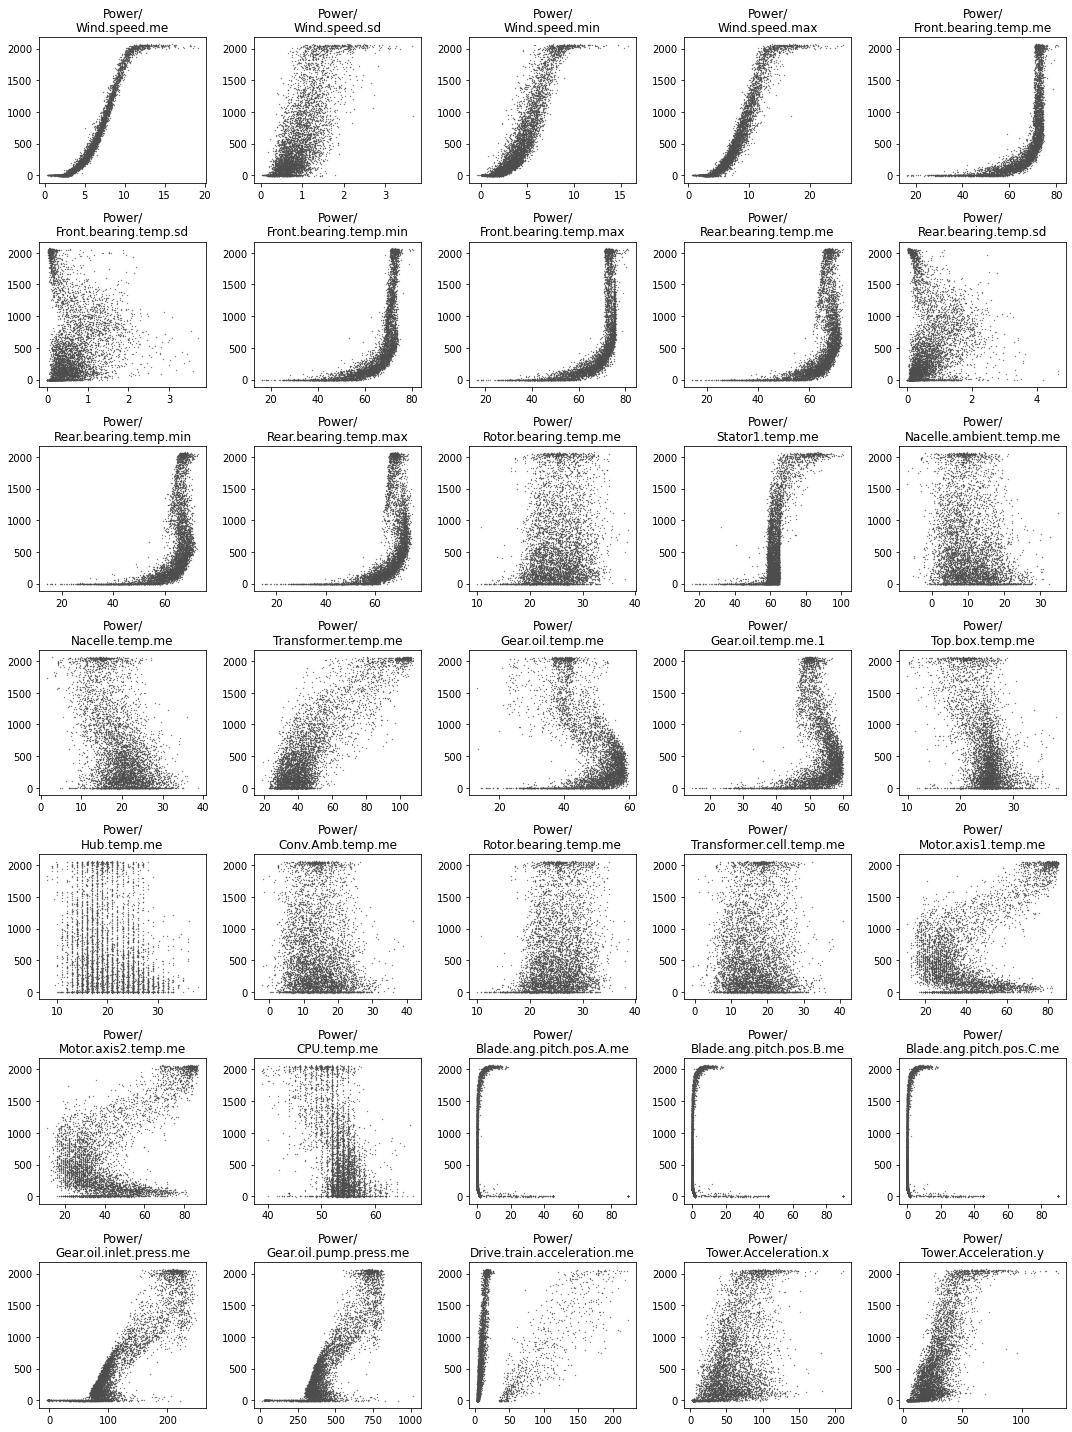

In [10]:
def plot_power_over_all_features(df, features, output_feature, sample_size=5000):
    df_sampled = df.sample(min(sample_size, len(df)))
    
    num_cols = 5
    num_rows = math.ceil(len(features) // num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        axes[i].scatter(x=df_sampled[feature], y=df_sampled[output_feature], alpha=0.7, color="0.3", linewidth=0, s=2)
        axes[i].set_title(f'Power/\n{feature}')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    plt.tight_layout()
    plt.show()
    
plot_power_over_all_features(df, features, output_feature, sample_size=5000)

These plots show, first of all, the non-linearity relationship between power output and operatioanl variables, and secondly, how the variance can significantly vary within features domains

In [11]:
def load_dataset_train_test_split(df, features, output_feature):
    X = df[features]
    y = df[output_feature]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

    # Scale input data to facilitate training
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, np.array(y_train), np.array(y_test), scaler

In [12]:
X_train, X_test, y_train, y_test, scaler = load_dataset_train_test_split(df, features, output_feature)

In [13]:
X_train.shape

(151504, 35)

In [14]:
# Set confidence interval to be considered as 'normal behaviour'
CONFIDENCE_INTERVAL = 0.99

In [15]:
def NLL(y, distr): 
    return -distr.log_prob(y) 

# We add 0.001 to the standard deviation to ensure it does not converge to 0 and destabilizes training because the gradient
# of maximum likelihood estimation requires the inversion of the variance. We also activate the parameters using a softplus
# activation function to enfore a positive standard deviation estimate.
def normal_softplus(params): 
    return tfd.Normal(loc=params[:, 0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:, 1:2]))

def multivariate_covariance_normal_softplus(mean_params, std_params, d): 
    means = mean_params
    stds = 1e-3 + tf.math.softplus(0.05 * std_params)
    
    return tfd.MultivariateNormalTriL(loc=means, scale_tril=tfp.math.fill_triangular(stds))

def multivariate_diagonal_normal_softplus(mean_params, std_params, d): 
    means = mean_params
    stds = 1e-3 + tf.math.softplus(0.05 * std_params)
    
    return tfd.MultivariateNormalDiag(loc=means, scale_diag=stds)

In [25]:
results = {}

## Standard (Homoscedastic) Neural Networks

We develop a deterministic multilayer perceptron (MLP) that uses as a loss function the mean squared error (MSE). The use of MSE as the loss function requires the assumption that the noise is identically and independently distributed accross the domain. The 'identically distributed' assumtpion assumes that the variance of the noise is not a function of the input parameters. Because of this, the deterministic MLP proposed below only accounts for homoscedastic sources of aleatoric and epistemic. However, the amount of error expressed by the model cannot be explicitly divided into epistemic and aleatoric uncertainty as the model does not explicitly output a distribution but a prediction. Confidence intervals can be derived as a function by assuming a gaussian distribution centred in the output of the network and with variance approximated by the MSE.

In [51]:
def create_model_mlp_non_probabilistic(X_train, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=(X_train.shape[1],))
    hidden = Dense(80, activation="relu")(inputs)
    hidden = Dense(50, activation="relu")(hidden)
    hidden = Dense(20, activation="relu")(hidden)
    output = Dense(1, activation="linear")(hidden) 

    model_mlp_non_probabilistic = Model(inputs=inputs, outputs=output)
    model_mlp_non_probabilistic.compile(Adam(learning_rate=0.001), loss='mean_squared_error')
    
    return model_mlp_non_probabilistic

model_mlp_non_probabilistic = create_model_mlp_non_probabilistic(X_train, MODELS_SEED)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 35)]              0         
                                                                 
 dense_16 (Dense)            (None, 80)                2880      
                                                                 
 dense_17 (Dense)            (None, 50)                4050      
                                                                 
 dense_18 (Dense)            (None, 20)                1020      
                                                                 
 dense_19 (Dense)            (None, 1)                 21        
                                                                 
Total params: 7971 (31.14 KB)
Trainable params: 7971 (31.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
4262/4262 [==

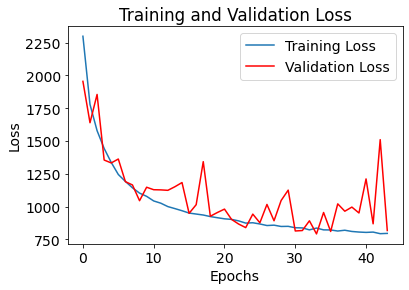

In [52]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_mlp_non_probabilistic.keras",
                                                 save_weights_only=True,
                                                 verbose=0)

history = train_model(model_mlp_non_probabilistic,
                      X_train, y_train,
                      patience=10, epochs=100, batch_size=32,
                      cp_callback=cp_callback)

plt.plot(history.history['loss'][1:], label='Training Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [53]:
model_mlp_non_probabilistic.load_weights("saved_models/model_mlp_non_probabilistic.keras")

In [54]:
model_mlp_non_probabilistic.evaluate(X_test, y_test)

1184/1184 [==============================] - 2s 2ms/step - loss: 781.2250


781.2250366210938

In [55]:
y_train_pred = np.array(model_mlp_non_probabilistic.predict(X_train)).ravel()
y_test_pred = np.array(model_mlp_non_probabilistic.predict(X_test)).ravel()

# We approximate the standard deviation of the assumed gaussian noise by using the RMSE of the prediction. This also assumes
# homoscedasticity nature of the noise.
y_train_stddevs = np.full(len(y_train_pred), np.sqrt(mean_squared_error(y_train, y_train_pred)))
y_test_stddevs = np.full(len(y_test_pred), np.sqrt(mean_squared_error(y_test, y_test_pred)))

evaluate_and_print_metrics(results, "Non-probabilistic MLP",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

1184/1184 [==============================] - 2s 2ms/step
Train RMSE: 27.512
Test RMSE: 27.950
Train MAE: 17.263
Test MAE: 17.527
Percentage of Train Data Points within 99.00% CI: 96.33%
Percentage of Test Data Points within 99.00% CI: 96.27%


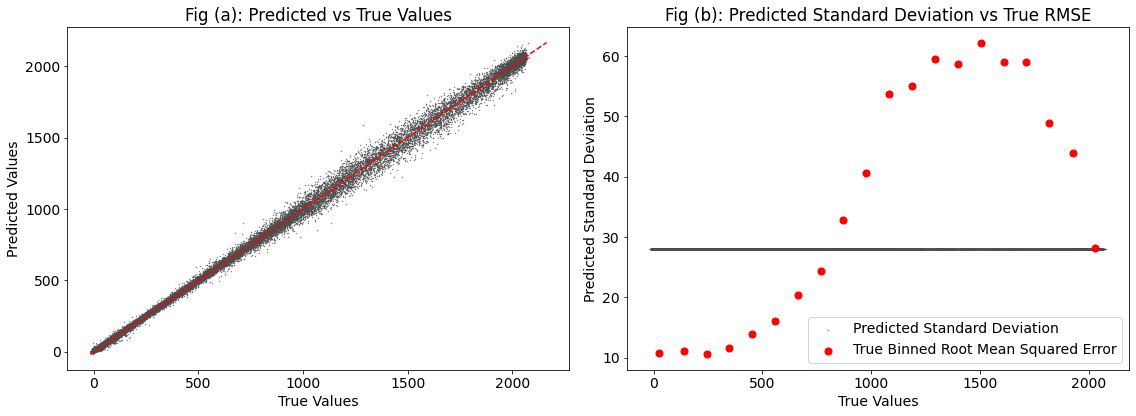

In [56]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

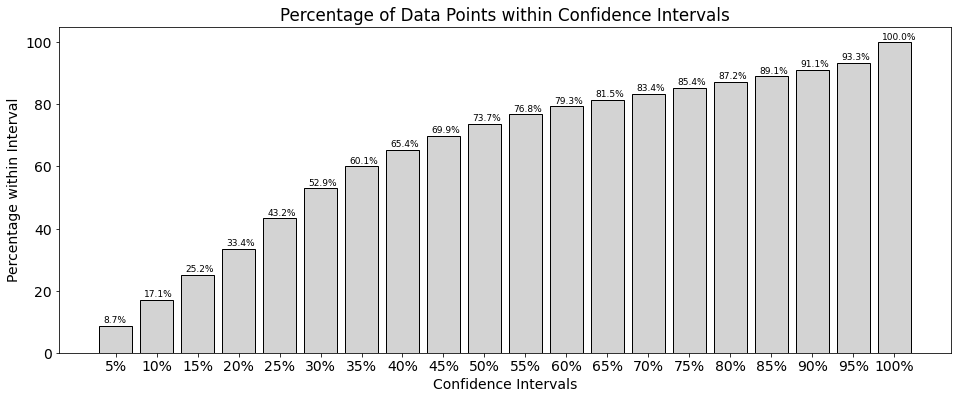

In [57]:
plot_confidence_interval_histogram(y_test_pred, y_test_stddevs, y_test, bins=20)

As you can see, althought the standard non-probabilistic neural network is an excellent approximator of the non linear relationship between SCADA variables and power output, as shown by the low RMSE, it is not a good model for evaluating uncertainty in prediction. It poorly overestimates uncertainty for power outputs, underestimates noise for mid-high power outputs, and again overestimates noise for the power outputs approaching 2000kW.

## Bayesian Neural Networks (Deterministic Output)

The purpose of introducing Bayesian Inference in neural networks is to introduce an estimation of the epistemic uncertainty (i.e., the uncertainty of the model - reducible with further training) of the model. In this framework, the model's weights are represented as posterior distributions instead of point-estimates. Therefore, as compared to traditional neural networks, the purpose of Bayesian Neural Network is to infere weight distributions from which an output given an input can be sampled. This represents the uncertainty of the model due to lack of data coverage. Typically, we expect epistemic uncertainty to be quite low for SCADA data sets as they provide large availability of data. 

BNN models are typically employed in data scarse systems, where identifying the uncertainty due to the lack of sufficient training is paramount. Because our dataset contains over 150,000 data entries, we expect low levels of epistemic uncertainty. This because it is possible to reduce epistemic uncertainty by giving the model sufficient representability capacity and train it over a sufficiently large dataset with respect to the number of model parameters. Nevertheless, we explore the use of BNN with deterministic output and probabilistic weights as a baseline model, and to show that most of the uncertainty in our regression task is given by irreducible noise and confirm that this is input-dependent. The models presented below leverage the approximate Bayesian Inference approach using Dense Flipout hidden layers. However, they have a non-probabilistic output, meaning it is unable to express heteroscedastic sources of aleatoric uncertainty. Again, because it minimizes the MSE, it assumes the data is distributed around an unknown function we are trying to approximate with an additive noise with homoscedastic variance.  

In particular, because of the higher computational complexity associated with BNNs as compared to standard neural networks, we have to reduce the size of our dataset to a 1% random sample.

In [18]:
SAMPLE_PERCENTAGE = 0.01
np.random.seed(MODELS_SEED)

sampled_indices = np.random.choice(len(X_train), int(len(X_train) * SAMPLE_PERCENTAGE), replace=False)
X_train_sampled = X_train[sampled_indices]
y_train_sampled = y_train[sampled_indices]

In [19]:
def compute_predictions(model, X_train, X_test, num_samples=100):
    y_train_pred = []
    y_test_pred = []
    for _ in range(num_samples):
        y_train_pred.append(model.predict(X_train))
        y_test_pred.append(model.predict(X_test))
        
    y_train_pred = np.concatenate(y_train_pred, axis=1)
    y_test_pred = np.concatenate(y_test_pred, axis=1)

    y_train_pred_mean = np.mean(y_train_pred, axis=1)
    y_train_pred_stddevs = np.std(y_train_pred, axis=1)
    
    y_test_pred_mean = np.mean(y_test_pred, axis=1)
    y_test_pred_stddevs = np.std(y_test_pred, axis=1)
    
    return y_train_pred_mean, y_train_pred_stddevs, y_test_pred_mean, y_test_pred_stddevs

### Dense Flipout Layers (sample data set)

Below it is presented a Bayesian multilayer perceptron (MLP) which approximates bayesian inference using Variational Inference via Flipout [1]. We specify Normal distributions with trainable parameters as weights for all hidden layers. In this case, we have an heteroscedastic epistemic and homoscedastic aleatoric model. The heteroscedasticity nature of the represented model uncertainty is derived through the use of probability distributions as weights, while the noise is still modelled with fixed variance (aleatoric homoscedasticity) because the network has a deterministic output that minimizes the MSE (this is equivalent to Maximum A Posteriori estimation of a symmetric distribution).


[1] Wen, Y., Vicol, P., Ba, J., Tran, D., & Grosse, R. (2018). Flipout: Efficient Pseudo-Independent weight perturbations on Mini-Batches. arXiv (Cornell University). https://doi.org/10.48550/arxiv.1803.04386

In [20]:
def create_model_mlp_non_probabilistic_bnn_flipout(X_train, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=(X_train.shape[1],))
    
    hidden1 = tfp.layers.DenseFlipout(
            units=30,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            activation = "relu"
        )(inputs)
    
    hidden2 = tfp.layers.DenseFlipout(
            units=30,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            activation = "relu"
        )(hidden1)
    
    hidden3 = tfp.layers.DenseFlipout(
            units=20,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            activation = "relu"
        )(hidden2)
    
    output = tfp.layers.DenseFlipout(
            units=1,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            activation = "relu"
        )(hidden2)

    model_mlp_non_probabilistic_bnn = Model(inputs=inputs, outputs=output)
    model_mlp_non_probabilistic_bnn.compile(Adam(learning_rate=0.001), loss='mean_squared_error')

    return model_mlp_non_probabilistic_bnn

model_mlp_non_probabilistic_bnn_flipout_sample = create_model_mlp_non_probabilistic_bnn_flipout(X_train_sampled, MODELS_SEED)

C:\Users\filip\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
C:\Users\filip\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 35)]              0         
                                                                 
 dense_flipout (DenseFlipou  (None, 30)                4230      
 t)                                                              
                                                                 
 dense_flipout_1 (DenseFlip  (None, 30)                3630      
 out)                                                            
                                                                 
 dense_flipout_3 (DenseFlip  (None, 1)                 121       
 out)                                                            
                                                                 
Total params: 7981 (31.18 KB)
Trainable params: 7981 (31.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________

43/43 [==============================] - 0s 7ms/step - loss: 5934.6113 - val_loss: 9293.5615
Epoch 67/100
43/43 [==============================] - 0s 7ms/step - loss: 5978.0737 - val_loss: 8865.6621
Epoch 68/100
43/43 [==============================] - 0s 6ms/step - loss: 5860.0127 - val_loss: 8549.3564
Epoch 69/100
43/43 [==============================] - 0s 6ms/step - loss: 5845.9077 - val_loss: 8514.8281
Epoch 70/100
43/43 [==============================] - 0s 6ms/step - loss: 5874.8940 - val_loss: 8512.8857
Epoch 71/100
43/43 [==============================] - 0s 7ms/step - loss: 5917.6318 - val_loss: 8651.8359
Epoch 72/100
43/43 [==============================] - 0s 8ms/step - loss: 5928.2900 - val_loss: 8620.0527
Epoch 73/100
43/43 [==============================] - 0s 6ms/step - loss: 5712.9121 - val_loss: 8312.9004
Epoch 74/100
43/43 [==============================] - 0s 7ms/step - loss: 5666.5220 - val_loss: 7851.8760
Epoch 75/100
43/43 [==============================] - 0s 6m

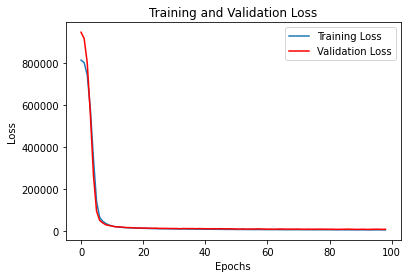

In [21]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_mlp_non_probabilistic_bnn_flipout_sample.keras",
                                                 save_weights_only=True,
                                                 verbose=0)

history = train_model(model_mlp_non_probabilistic_bnn_flipout_sample,
                      X_train_sampled, y_train_sampled,
                      patience=20, epochs=100, batch_size=256,
                      cp_callback=cp_callback)

plt.plot(history.history['loss'][1:], label='Training Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [22]:
# Load the model weights
model_mlp_non_probabilistic_bnn_flipout_sample.load_weights("saved_models/model_mlp_non_probabilistic_bnn_flipout_sample.keras")

In [23]:
y_train_pred_mean, y_train_pred_stddevs, \
y_test_pred_mean, y_test_pred_stddevs = \
compute_predictions(model_mlp_non_probabilistic_bnn_flipout_sample, X_train, X_test, num_samples=20)

1184/1184 [==============================] - 3s 3ms/step


In [26]:
y_train_pred = y_train_pred_mean.ravel()
y_test_pred = y_test_pred_mean.ravel()

y_train_stddevs = y_train_pred_stddevs.ravel()
y_test_stddevs = y_test_pred_stddevs.ravel()

evaluate_and_print_metrics(results, f"Epistemic Uncertainty BNN (Flipout) - {SAMPLE_PERCENTAGE*100}% Sample", y_train, y_test, y_train_pred, y_test_pred, y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

Train RMSE: 72.878
Test RMSE: 72.638
Train MAE: 48.414
Test MAE: 48.254
Percentage of Train Data Points within 99.00% CI: 34.33%
Percentage of Test Data Points within 99.00% CI: 34.28%


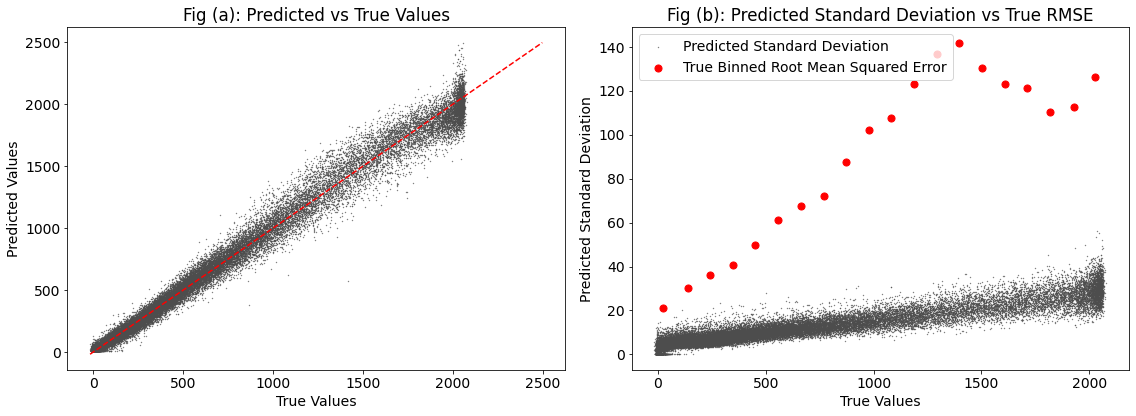

In [27]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

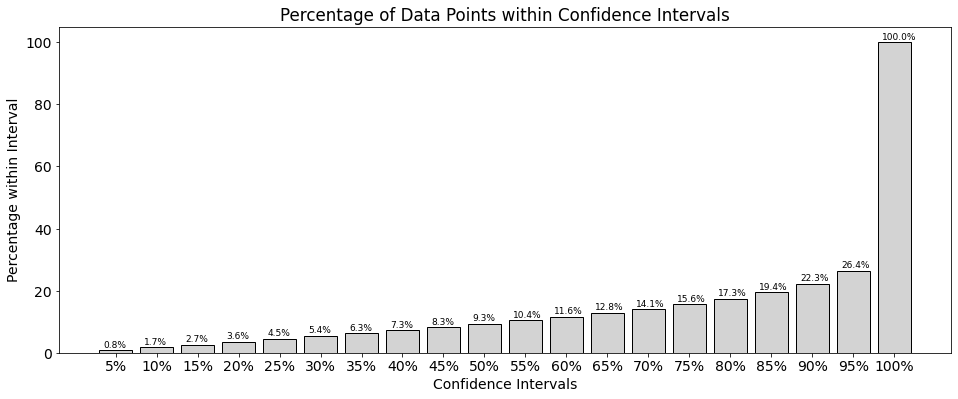

In [28]:
plot_confidence_interval_histogram(y_test_pred, y_test_stddevs, y_test, bins=20)

The RMSE of the of the model is high. We explore if this can be reduced with further training by considering the full training data set.

### Dense Flipout Layers (full data set)

An equivalent model as shown above, but trained over the full dataset. We show how further training can reduce epistemic uncertainty and decrease the prediction error of the model. However, we show how this is not fully representative of the uncertainty in the system, since most of the uncertainty is given by the variance of the noise, which we cannot model with a deterministic output.

In [105]:
model_mlp_non_probabilistic_bnn_flipout = create_model_mlp_non_probabilistic_bnn_flipout(X_train, MODELS_SEED)

C:\Users\filip\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
C:\Users\filip\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_mlp_non_probabilistic_bnn_flipout.keras",
                                                 save_weights_only=True,
                                                 verbose=0)

history = train_model(model_mlp_non_probabilistic_bnn_flipout,
                      X_train, y_train,
                      patience=20, epochs=400, batch_size=256,
                      cp_callback=cp_callback)

plt.plot(history.history['loss'][1:], label='Training Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 35)]              0         
                                                                 
 dense_flipout_11 (DenseFli  (None, 30)                4230      
 pout)                                                           
                                                                 
 dense_flipout_12 (DenseFli  (None, 30)                3630      
 pout)                                                           
                                                                 
 dense_flipout_14 (DenseFli  (None, 1)                 121       
 pout)                                                           
                                                                 
Total params: 7981 (31.18 KB)
Trainable params: 7981 (31.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________

In [ ]:
# Load the model weights
model_mlp_non_probabilistic_bnn_flipout.load_weights("saved_models/model_mlp_non_probabilistic_bnn_flipout.keras")

In [ ]:
model_mlp_non_probabilistic_bnn_flipout.evaluate(X_test, y_test)

In [ ]:
y_train_pred_mean, y_train_pred_stddevs, \
y_test_pred_mean, y_test_pred_stddevs = \
compute_predictions(model_mlp_non_probabilistic_bnn_flipout, X_train, X_test, num_samples=20)

In [ ]:
y_train_pred = y_train_pred_mean.ravel()
y_test_pred = y_test_pred_mean.ravel()

y_train_stddevs = y_train_pred_stddevs.ravel()
y_test_stddevs = y_test_pred_stddevs.ravel()

evaluate_and_print_metrics(results, "Epistemic Uncertainty BNN (Flipout)", y_train, y_test, y_train_pred, y_test_pred, y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

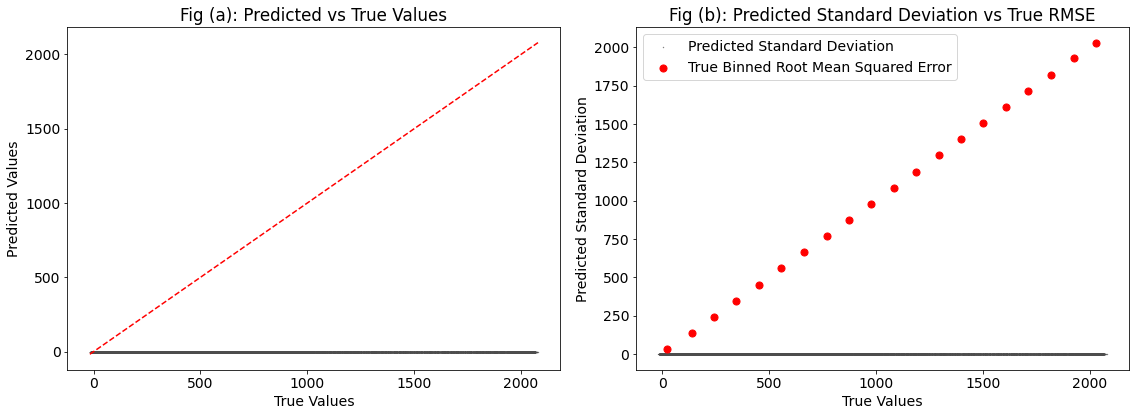

In [49]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

In [ ]:
plot_confidence_interval_histogram(y_test_pred, y_test_stddevs, y_test, bins=20)

##### Feature Importance

For the interest of the field we evaluate the raw feature importance within the Bayesian network. Let's evaluate feature importance for the BNN with deterministic output. We do this only for the deterministic output because the RATE library does not support probabilistic regressions (see https://github.com/lorinanthony/RATE). To do so we retrain the model wrapped into a BNN_Regressor class from the RATE library.

In [ ]:
p = X_test.shape[1]

kl_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] * 1.0)

layers = []

layers.append(tfp.layers.DenseFlipout(
        units=30,
        input_shape=(p,),
        kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
        kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
        kernel_divergence_fn = kl_divergence_fn,
        activation = "relu"
    ))

layers.append(tfp.layers.DenseFlipout(
        units=30,
        kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
        kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
        kernel_divergence_fn = kl_divergence_fn,
        activation = "relu"
    ))

layers.append(tfp.layers.DenseFlipout(
        units=20,
        kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
        kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
        kernel_divergence_fn = kl_divergence_fn,
        activation = "relu"
    ))

layers.append(tfp.layers.DenseFlipout(
        units=1,
        kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
        kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
        kernel_divergence_fn = kl_divergence_fn,
        activation = "linear"
    ))

bnn = BNN_Regressor(layers, p=p)
fit_history = bnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1,
                    callbacks=[EarlyStopping(monitor="val_loss", patience=5)],
                    verbose=1)

sampled_indices = np.random.choice(len(X_train), 10000, replace=False)
X_test_sampled = X_train[sampled_indices]
y_test_sampled = y_train[sampled_indices]

ratings = RATE_BNN(bnn, X_test_sampled, n_workers=1)

In [ ]:
sampled_indices = np.random.choice(len(X_train), 10000, replace=False)
X_test_sampled = X_train[sampled_indices]
y_test_sampled = y_train[sampled_indices]

rates = RATE_BNN(bnn, X_test_sampled, n_workers=1)
feature_importance = {feature: rate for feature, rate in zip(features, list(rates[0]))}

In [ ]:
feature_importance

In [ ]:
features = list(feature_importance.keys())
importance_values = list(feature_importance.values())

plt.figure(figsize=(10, 12))
plt.barh(features, importance_values, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

While the deterministic Bayesian deep model presents very low RMSE, it is a poor approximator of the overall uncertainty of the model. This because it can only express the intrinsic uncertainty of the model caused by insufficient training or lack of expressivity of the model. However, since the epistemic uncertainty is evaluated as very low, it appears that the prediction residuals of the model are mostly caused by noise, which we cannot fully model with a non-probabilistic output. Moreover, the epistemic uncertainty is estimated as independent of the output true values.

## Bayesian Neural Networks (Probabilistic Output)

We introduce a probabilistic output to a bayesian netwrok with the same number of layers as the previous but more hidden units. This way we model the output as a univariate distribution parametrized via a mean and a variance functions in the input space of the network. The loss becomes the negative log-likelihood of the identically and indipendently distributed data points. Where the distribution is a univariate Normal with a mean function and variance function paramettrized by the model.

### Dense Flipout + Gaussian Output

In [50]:
def create_model_bnn(X_train, seed):
    keras.utils.set_random_seed(seed) 
    
    kl_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] * 1.0)
        
    inputs = Input(shape=(X_train.shape[1],))
    
    hidden1 = tfp.layers.DenseFlipout(
            units=80,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        )(inputs)
    
    hidden2 = tfp.layers.DenseFlipout(
            units=50,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        )(hidden1)
    
    hidden3 = tfp.layers.DenseFlipout(
            units=20,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        )(hidden2)
    
    # Output Univariate Normal Probabilistic Layer
    dist_params = Dense(2)(hidden3)
    dist = tfp.layers.DistributionLambda(normal_softplus)(dist_params)

    model_bnn = Model(inputs=inputs, outputs=dist)
    model_bnn.compile(Adam(learning_rate=0.001), loss=NLL)

    return model_bnn

model_bnn = create_model_bnn(X_train, MODELS_SEED)

C:\Users\filip\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
C:\Users\filip\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_bnn.keras",
                                                 save_weights_only=True,
                                                 verbose=0)
history = train_model(model_bnn,
                      X_train, y_train,
                      patience=10, epochs=100, batch_size=256,
                      cp_callback=cp_callback)

plt.plot(history.history['loss'][1:], label='Training Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [51]:
model_bnn.load_weights("saved_models/model_bnn.keras")

In [52]:
model_bnn.evaluate(X_test, y_test)

1184/1184 [==============================] - 2s 2ms/step - loss: 3.7534


3.7534000873565674

In [53]:
y_train_pred = np.array(model_bnn(X_train).mean()).ravel()
y_test_pred = np.array(model_bnn(X_test).mean()).ravel()

y_train_stddevs = np.array(model_bnn(X_train).stddev()).ravel()
y_test_stddevs = np.array(model_bnn(X_test).stddev()).ravel()

evaluate_and_print_metrics(results, "Aleatoric & Epistemic Uncertainty BNN (Flipout)",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

Train RMSE: 26.632
Test RMSE: 27.125
Train MAE: 14.529
Test MAE: 14.780
Percentage of Train Data Points within 99.00% CI: 98.78%
Percentage of Test Data Points within 99.00% CI: 98.50%


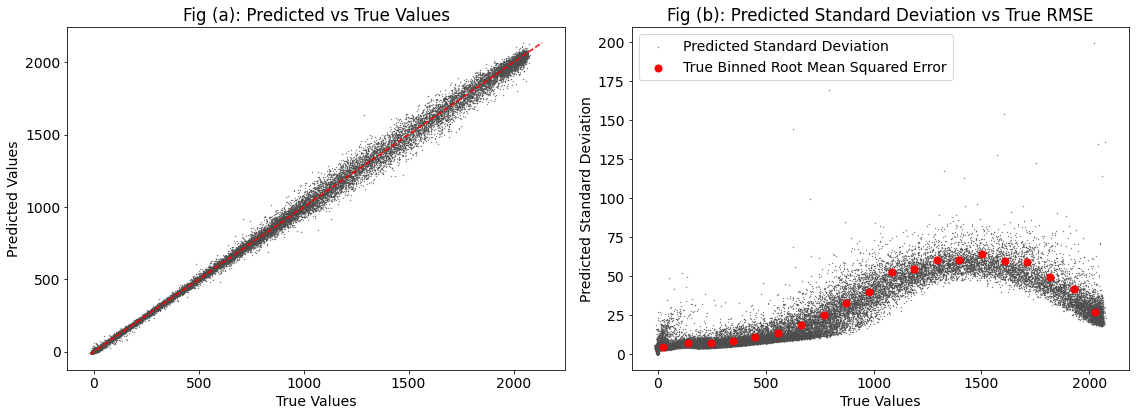

In [54]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

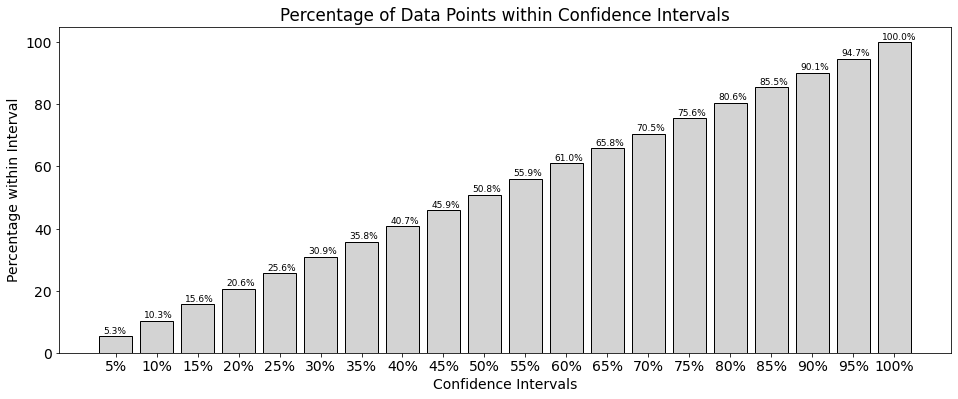

In [55]:
plot_confidence_interval_histogram(y_test_pred, y_test_stddevs, y_test, bins=20)

## Non-Bayesian
We create a non-Bayesian deep model for the mean and the standard deviation of a Gaussian. 

### Deep Neural Network with Gaussian Output (Separate Submodels)

Two identical and parallel networks process the input data independently to estimate the mean and variance parameters. These two sub-models employ three hidden layers with ReLU activation functions to capture non-linearity in the system with increasing levels of abstraction. The final layers of these sub-models are merged into a single output layer with two units, one for the predicted mean and one for the predicted variance). The loss is the negative log-likelihood of the Normal parametrized by these sub-models. This means, that, although the two sub-models extract independent non-linear features, they are trained simultaneously to minimize a common loss. 

In [56]:
def create_model_mlp_gaussian_separate(X_train, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=(X_train.shape[1],))
    mean_h1 = Dense(80, activation="relu")(inputs)
    variance_h1 = Dense(80, activation="relu")(inputs)
    
    mean_h2 = Dense(50, activation="relu")(mean_h1)
    variance_h2 = Dense(50, activation="relu")(variance_h1)
    
    mean_h3 = Dense(20, activation="relu")(mean_h2)
    variance_h3 = Dense(20, activation="relu")(variance_h2)
    
    mean_h4 = Dense(20, activation="relu")(mean_h3)
    variance_h4 = Dense(20, activation="relu")(variance_h3)
    
    mean_out = Dense(1)(mean_h4)
    variance_out = Dense(1)(variance_h4)
    
    params = Concatenate()([mean_out, variance_out])
    
    dist = tfp.layers.DistributionLambda(normal_softplus)(params) 

    model_mlp_gaussian = Model(inputs=inputs, outputs=dist)
    model_mlp_gaussian.compile(Adam(learning_rate=0.001), loss=NLL)

    return model_mlp_gaussian

model_mlp_gaussian_separate = create_model_mlp_gaussian_separate(X_train, MODELS_SEED)

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_mlp_gaussian_separate.keras",
                                                 save_weights_only=True,
                                                 verbose=0)
history = train_model(model_mlp_gaussian_separate,
                      X_train, y_train,
                      patience=15, epochs=100, batch_size=32,
                      cp_callback=cp_callback)

plt.plot(history.history['loss'][1:], label='Training Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [57]:
model_mlp_gaussian_separate.load_weights("saved_models/model_mlp_gaussian_separate.keras")

In [58]:
model_mlp_gaussian_separate.evaluate(X_test, y_test)

1184/1184 [==============================] - 1s 972us/step - loss: 3.8355


3.8355445861816406

In [60]:
y_train_pred = np.array(model_mlp_gaussian_separate(X_train).mean()).ravel()
y_test_pred = np.array(model_mlp_gaussian_separate(X_test).mean()).ravel()

y_train_stddevs = np.array(model_mlp_gaussian_separate(X_train).stddev()).ravel()
y_test_stddevs = np.array(model_mlp_gaussian_separate(X_test).stddev()).ravel()

evaluate_and_print_metrics(results, "Non-Bayesian MLP with Gaussian Output (Separate Sub-models)",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

Train RMSE: 30.143
Test RMSE: 30.479
Train MAE: 16.457
Test MAE: 16.609
Percentage of Train Data Points within 99.00% CI: 99.01%
Percentage of Test Data Points within 99.00% CI: 98.91%


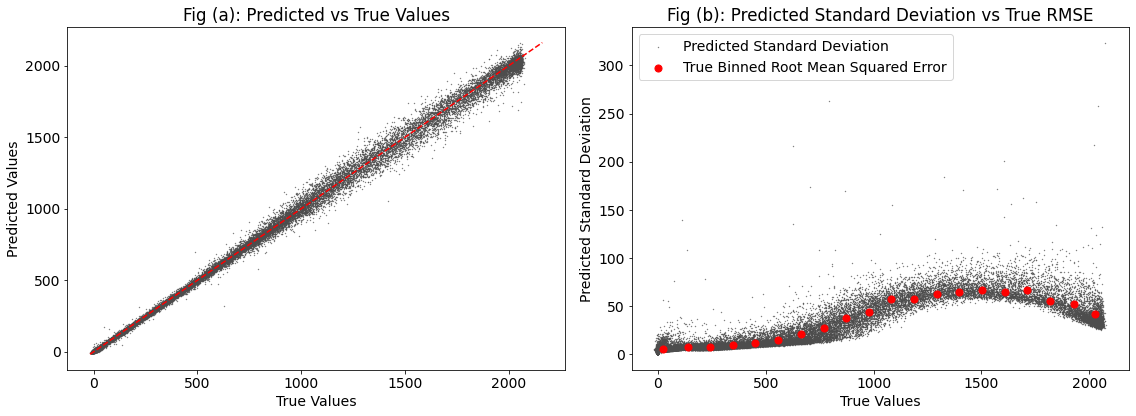

In [61]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

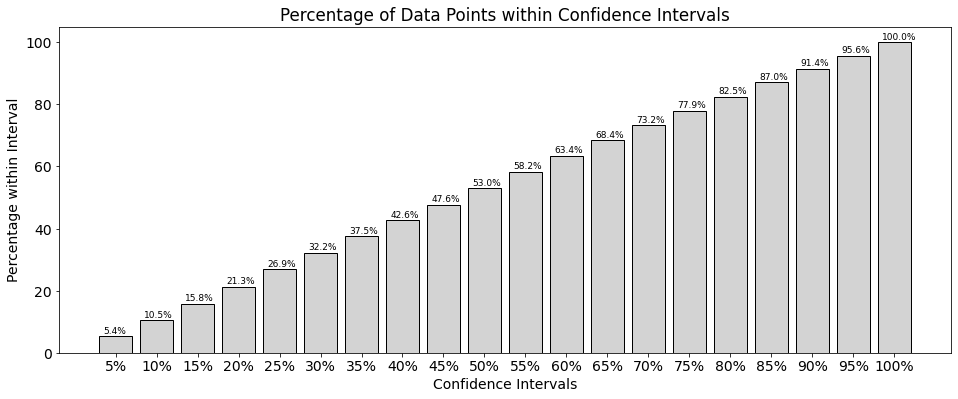

In [62]:
plot_confidence_interval_histogram(y_test_pred, y_test_stddevs, y_test, bins=20)

### Deep Neural Network with Gaussian Output (Joint Submodels)

A shared deep feature extractor sub-model is followed by two shallow sub-models with a single hidden layer and a single-unit output layer respectively. The first shared sub-model extract non-linear features from the input space, and the separate models estimate mean and variance respectively using non-linear combinations of the features extracted by the shared sub-model. The two single-unit outputs of the mean and variance sub-models are concatenated to represent the parameters of a univariate Normal.

In [63]:
def create_model_mlp_gaussian_joint(X_train, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=(X_train.shape[1],))
    
    hidden1 = Dense(100, activation="relu")(inputs)
    hidden2 = Dense(80, activation="relu")(hidden1)
    hidden3 = Dense(40, activation="relu")(hidden2)
    
    mean_h1 = Dense(20, activation="relu")(hidden3)
    mean_out = Dense(1)(mean_h1)
    
    variance_h1 = Dense(20, activation="relu")(hidden3)
    variance_out = Dense(1)(variance_h1)
    
    params = Dense(2)(Concatenate()([mean_out, variance_out]))

    
    dist = tfp.layers.DistributionLambda(normal_softplus)(params) 

    model_mlp_gaussian = Model(inputs=inputs, outputs=dist)
    model_mlp_gaussian.compile(Adam(learning_rate=0.001), loss=NLL)

    return model_mlp_gaussian

model_mlp_gaussian_joint = create_model_mlp_gaussian_joint(X_train, MODELS_SEED)

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_mlp_gaussian_joint.keras",
                                                 save_weights_only=True,
                                                 verbose=0)
history = train_model(model_mlp_gaussian_joint,
                      X_train, y_train,
                      patience=15, epochs=100, batch_size=32,
                      cp_callback=cp_callback)

plt.plot(history.history['loss'][1:], label='Training Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [64]:
model_mlp_gaussian_joint.load_weights("saved_models/model_mlp_gaussian_joint.keras")

In [65]:
model_mlp_gaussian_joint.evaluate(X_test, y_test)

1184/1184 [==============================] - 1s 1ms/step - loss: 3.7256


3.725611925125122

In [66]:
y_train_pred = np.array(model_mlp_gaussian_joint(X_train).mean()).ravel()
y_test_pred = np.array(model_mlp_gaussian_joint(X_test).mean()).ravel()

y_train_stddevs = np.array(model_mlp_gaussian_joint(X_train).stddev()).ravel()
y_test_stddevs = np.array(model_mlp_gaussian_joint(X_test).stddev()).ravel()

evaluate_and_print_metrics(results, "Non-Bayesian MLP with Gaussian Output (Joint Sub-models)",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

Train RMSE: 26.169
Test RMSE: 26.890
Train MAE: 14.254
Test MAE: 14.578
Percentage of Train Data Points within 99.00% CI: 99.14%
Percentage of Test Data Points within 99.00% CI: 98.89%


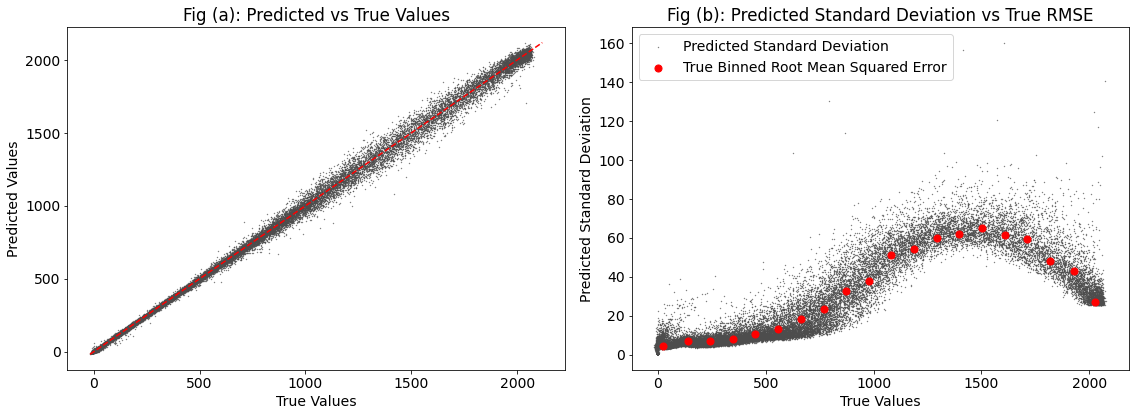

In [67]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

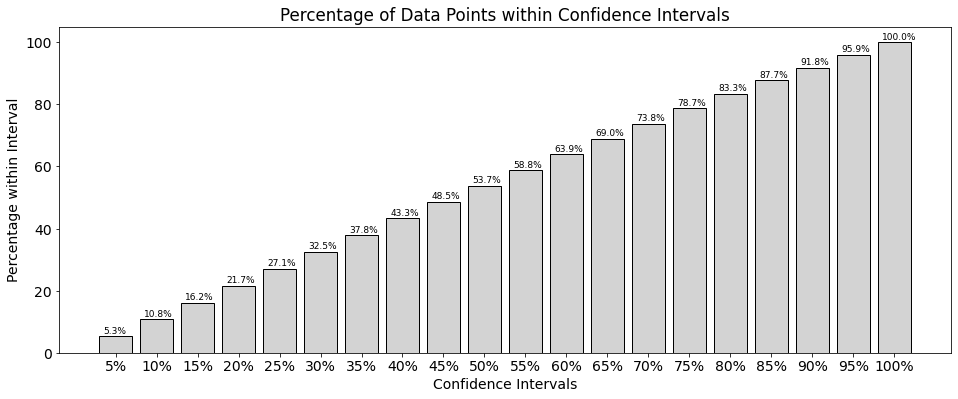

In [68]:
plot_confidence_interval_histogram(y_test_pred, y_test_stddevs, y_test, bins=20)

By comparing the two architecture it is clear that a separate set of features decreases the model's out-of-sample error. Therefore, the proposed model in the study is the first. 

### Deep Neural Network with Gaussian Output (Joint Submodels) - Averaged over Seeds

We average our proposed model over 5 different random seed for initializing the vector weight to show that our model is robust to the randomness of weight initialization. We demonstrate this by showing a very low standard deviation over the sample set.

In [112]:
rmses = []
maes = []
percentages = []
NUM_SEED = 5

for seed in range(NUM_SEED):
    model_mlp_gaussian_joint = create_model_mlp_gaussian_joint(X_train, seed)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"saved_models/model_mlp_gaussian_joint_{seed}.keras",
                                                 save_weights_only=True,
                                                 verbose=0)
    history = train_model(model_mlp_gaussian_joint,
                      X_train, y_train,
                      patience=15, epochs=100, batch_size=32,
                      cp_callback=cp_callback)
    
    z_value = stats.norm.ppf((1 + CONFIDENCE_INTERVAL) / 2)
    
    y_test_pred = np.array(model_mlp_gaussian_joint(X_test).mean()).ravel()
    y_test_stddevs = np.array(model_mlp_gaussian_joint(X_test).stddev()).ravel()
    
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = np.sqrt(mean_absolute_error(y_test, y_test_pred))

    test_lower_bound = y_test_pred - z_value * y_test_stddevs
    test_upper_bound = y_test_pred + z_value * y_test_stddevs

    test_within_interval = np.sum(np.logical_and(y_test.ravel() >= test_lower_bound, y_test.ravel() <= test_upper_bound))
    test_percentage_within_interval = (test_within_interval / len(y_test.ravel())) * 100
    
    rmses.append(test_rmse)
    maes.append(test_mae)
    percentages.append(test_percentage_within_interval)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 35)]                 0         []                            
                                                                                                  
 dense_127 (Dense)           (None, 100)                  3600      ['input_13[0][0]']            
                                                                                                  
 dense_128 (Dense)           (None, 80)                   8080      ['dense_127[0][0]']           
                                                                                                  
 dense_129 (Dense)           (None, 40)                   3240      ['dense_128[0][0]']           
                                                                                            

4262/4262 [==============================] - 14s 3ms/step - loss: 4.0111 - val_loss: 4.0533
Epoch 14/100
4262/4262 [==============================] - 16s 4ms/step - loss: 3.9948 - val_loss: 4.1128
Epoch 15/100
4262/4262 [==============================] - 15s 3ms/step - loss: 3.9717 - val_loss: 4.3283
Epoch 16/100
4262/4262 [==============================] - 14s 3ms/step - loss: 3.9618 - val_loss: 4.1592
Epoch 17/100
4262/4262 [==============================] - 13s 3ms/step - loss: 3.9465 - val_loss: 4.4963
Epoch 18/100
4262/4262 [==============================] - 13s 3ms/step - loss: 3.9328 - val_loss: 4.0318
Epoch 19/100
4262/4262 [==============================] - 13s 3ms/step - loss: 3.9188 - val_loss: 3.9782
Epoch 20/100
4262/4262 [==============================] - 13s 3ms/step - loss: 3.9101 - val_loss: 4.0217
Epoch 21/100
4262/4262 [==============================] - 14s 3ms/step - loss: 3.8975 - val_loss: 3.8651
Epoch 22/100
4262/4262 [==============================] - 13s 3ms/st

                                                                                                  
 dense_153 (Dense)           (None, 40)                   3240      ['dense_152[0][0]']           
                                                                                                  
 dense_154 (Dense)           (None, 20)                   820       ['dense_153[0][0]']           
                                                                                                  
 dense_156 (Dense)           (None, 20)                   820       ['dense_153[0][0]']           
                                                                                                  
 dense_155 (Dense)           (None, 1)                    21        ['dense_154[0][0]']           
                                                                                                  
 dense_157 (Dense)           (None, 1)                    21        ['dense_156[0][0]']           
          

4262/4262 [==============================] - 15s 4ms/step - loss: 3.8933 - val_loss: 3.8941
Epoch 24/100
4262/4262 [==============================] - 15s 4ms/step - loss: 3.8790 - val_loss: 3.9201
Epoch 25/100
4262/4262 [==============================] - 15s 4ms/step - loss: 3.8715 - val_loss: 3.8880
Epoch 26/100
4262/4262 [==============================] - 15s 4ms/step - loss: 3.8640 - val_loss: 4.4657
Epoch 27/100
4262/4262 [==============================] - 15s 4ms/step - loss: 3.8569 - val_loss: 3.9602
Epoch 28/100
4262/4262 [==============================] - 16s 4ms/step - loss: 3.8465 - val_loss: 3.7915
Epoch 29/100
4262/4262 [==============================] - 18s 4ms/step - loss: 3.8460 - val_loss: 3.8048
Epoch 30/100
4262/4262 [==============================] - 18s 4ms/step - loss: 3.8384 - val_loss: 3.7957
Epoch 31/100
4262/4262 [==============================] - 15s 4ms/step - loss: 3.8334 - val_loss: 4.0320
Epoch 32/100
4262/4262 [==============================] - 15s 4ms/st

In [113]:
print(f"Mean of RMSEs over {NUM_SEED} seeds: {np.array(rmses).mean()}")
print(f"Standard deviation of RMSEs over {NUM_SEED} seeds: {np.array(rmses).std()}")

print(f"Mean of MAEs over {NUM_SEED} seeds: {np.array(rmses).mean()}")
print(f"Standard deviation of MAEs over {NUM_SEED} seeds: {np.array(rmses).std()}")

print(f"Mean of percentages in {CONFIDENCE_INTERVAL} C.I. over {NUM_SEED} seeds: {np.array(rmses).mean()}")
print(f"Standard deviation of percentages in {CONFIDENCE_INTERVAL} C.I. over {NUM_SEED} seeds: {np.array(rmses).std()}")

Mean of RMSEs over 5 seeds: 27.292016640113694
Standard deviation of RMSEs over 5 seeds: 0.5800149701689128
Mean of MAEs over 5 seeds: 27.292016640113694
Standard deviation of MAEs over 5 seeds: 0.5800149701689128
Mean of percentages in 0.99 C.I. over 5 seeds: 27.292016640113694
Standard deviation of percentages in 0.99 C.I. over 5 seeds: 0.5800149701689128


As predicted, the RMSE is inline with what we had for a single seed, moreover, the standard deviation is very low. This shows how our model is robust to the randomness of the weight initialization.

Below are presented a set of model that have been tested as potential coompetitors to the finalized model above. They have been presented here as they represent more complicated ways of leveraging deep learning as a tool for normal behaviour modelling of wind turbines power curve. However, the increased complexity of the model did not who improvements in performance, therefore the simpler and more robust model presented above was chosen as th ebest candidate.

## Additional Models

### CNN with Gaussian Output

In light of a study conducted by et al. [2], we propose the use of a 1-D CNN to be used as an extractor of spatial features within out feature space. While this model is purely exploratory, we expect this not to excel, because of the almost non-existent spatial dependecy among features. In simpler terms, because CNNs capture spatial features, they are extremely dependent in the order of the features. In our case, the ordering of the features as little predictive significance, so the use of a convolution over the feature space of the input is not really empirically justified.

[2] Xiang, L., Wang, P., Yang, X., Hu, A., & Su, H. (2021). Fault de-
tection of wind turbine based on SCADA data analysis using CNN
and LSTM with an attention mechanism. Measurement, 175, 109094.
https://doi.org/10.1016/j.measurement.2021.109094

In [31]:
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [36]:
def create_model_cnn_gaussian(X_train, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=(X_train_cnn.shape[1], 1))
    conv1d_layer = Conv1D(filters=32, kernel_size=5, activation='relu')(inputs)
    maxpooling_layer = MaxPooling1D(pool_size=2)(conv1d_layer)
    
    flatten_layer = Flatten()(maxpooling_layer)
 
    hidden1 = Dense(50, activation="relu")(flatten_layer)
    hidden2 = Dense(50, activation="relu")(hidden1)
    hidden3 = Dense(20, activation="relu")(hidden2)
    
    params = Dense(2)(hidden3)
    dist = tfp.layers.DistributionLambda(normal_softplus)(params) 

    model_cnn_gaussian = Model(inputs=inputs, outputs=dist)
    model_cnn_gaussian.compile(Adam(learning_rate=0.001), loss=NLL)
    
    return model_cnn_gaussian

model_cnn_gaussian = create_model_cnn_gaussian(X_train_cnn, MODELS_SEED)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 35, 1)]           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 31, 32)            192       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 15, 32)            0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 480)               0         
                                                                 
 dense_12 (Dense)            (None, 50)                24050     
                                                                 
 dense_13 (Dense)            (None, 50)                2550      
                                                           

4262/4262 [==============================] - 14s 3ms/step - loss: 3.9157 - val_loss: 3.9927
Epoch 63/100
4262/4262 [==============================] - 14s 3ms/step - loss: 3.9121 - val_loss: 3.9935
Epoch 64/100
4262/4262 [==============================] - 14s 3ms/step - loss: 3.9087 - val_loss: 3.9191
Epoch 65/100
4262/4262 [==============================] - 14s 3ms/step - loss: 3.9052 - val_loss: 3.9831
Epoch 66/100
4262/4262 [==============================] - 14s 3ms/step - loss: 3.9241 - val_loss: 4.0214
Epoch 67/100
4262/4262 [==============================] - 14s 3ms/step - loss: 3.9016 - val_loss: 3.8775
Epoch 68/100
4262/4262 [==============================] - 14s 3ms/step - loss: 3.9015 - val_loss: 3.9388
Epoch 69/100
4262/4262 [==============================] - 14s 3ms/step - loss: 3.8996 - val_loss: 3.9066
Epoch 70/100
4262/4262 [==============================] - 15s 3ms/step - loss: 3.8970 - val_loss: 4.0183
Epoch 71/100
4262/4262 [==============================] - 15s 3ms/st

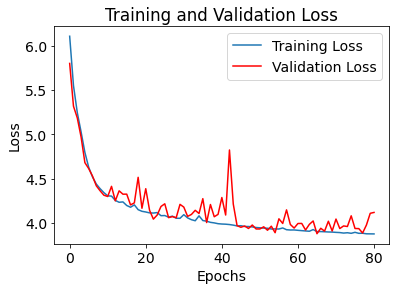

In [37]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_cnn_gaussian.keras",
                                                 save_weights_only=True,
                                                 verbose=0)
history = train_model(model_cnn_gaussian,
                      X_train_cnn, y_train,
                      patience=15, epochs=100, batch_size=32,
                      cp_callback=cp_callback)

plt.plot(history.history['loss'][1:], label='Training Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [38]:
model_cnn_gaussian.evaluate(X_test_cnn, y_test)

1184/1184 [==============================] - 4s 3ms/step - loss: 3.8709


3.8709070682525635

In [39]:
y_train_pred = np.array(model_cnn_gaussian(X_train_cnn).mean()).ravel()
y_test_pred = np.array(model_cnn_gaussian(X_test_cnn).mean()).ravel()

y_train_stddevs = np.array(model_cnn_gaussian(X_train_cnn).stddev()).ravel()
y_test_stddevs = np.array(model_cnn_gaussian(X_test_cnn).stddev()).ravel()

evaluate_and_print_metrics(results, "Non-Bayesian CNN with Gaussian Output",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

Train RMSE: 28.965
Test RMSE: 29.602
Train MAE: 16.005
Test MAE: 16.364
Percentage of Train Data Points within 99.00% CI: 98.75%
Percentage of Test Data Points within 99.00% CI: 98.52%


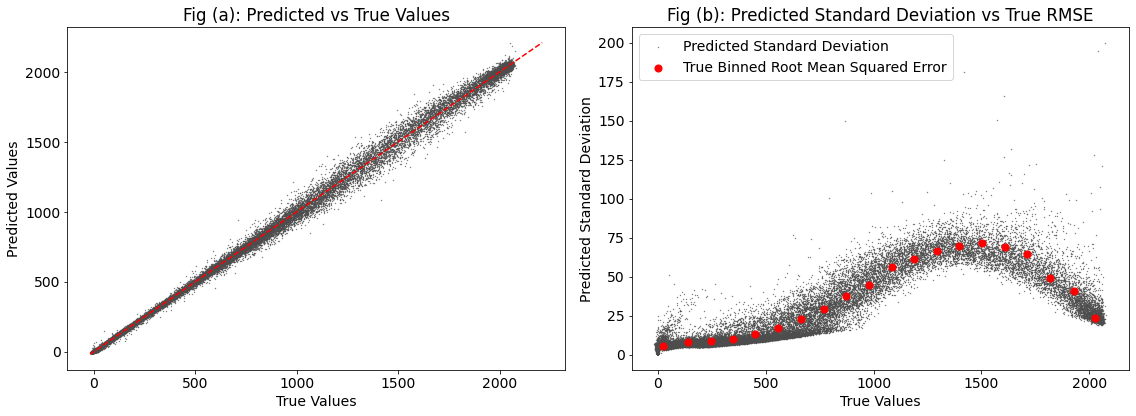

In [40]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

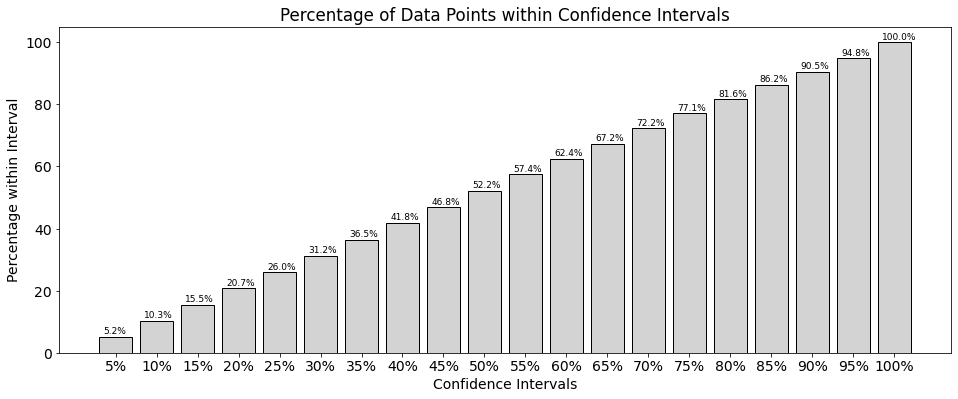

In [41]:
plot_confidence_interval_histogram(y_test_pred, y_test_stddevs, y_test, bins=20)

Clearly, the model is underperforming as compared to the MLP model with Normal output. This is probably the case because the features extracted by the Convolution layer have little significance. 

### Modelling Multiple Turbines: a Multivariate Experiment

We present below an experiment consisting of multi-turbine modelling. The reasoning motivating this research comes from studying and modelling the correlation between different turbines and investigating whether this can improve the predictive performance of the multivariate model. Below are presented deep networks with multivariate outputs for the 6 turbines. The output is a multivariate Gaussian of which we model the mean vector and lower triangular matrix of its Cholesky decomposition. In this case, the negative log likelihood is:

$$
\text{NLL}(\mu, \Sigma) = \sum_{i=1}^{n} -\frac{1}{2} \left[ d \cdot \log(2\pi) + \log\left(|(\Sigma(\mathbf{x}_i))|\right) + (\mathbf{y}_i - \boldsymbol{\mu(\mathbf{x}_i)})^T (\Sigma(\mathbf{x}_i))^{-1} (\mathbf{y}_i - \boldsymbol{\mu(\mathbf{x}_i)}) \right]
$$

In [43]:
def flatten_dataframe(df, features, output_feature, date_col):
    df['turbine_id'] = df['turbine']
    df = df.pivot(index=date_col, columns='turbine_id', values=features + [output_feature])
    df.columns = ['_'.join(map(str, col)).strip() for col in df.columns.values]
    return df

In [44]:
def train_multivariate_model(model, X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, patience=10):
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    model.build(X_train.shape)
    model.summary()

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[early_stopping]
    )

    return history

In [45]:
# Specify the number of turbines to consider
turbine_num = 6

# Select the two turbines with the most common non-NaN data points
turbine_counts = df_full.groupby('turbine').apply(lambda x: x.notna().all(axis=1).sum())
turbine_ids = turbine_counts.nlargest(turbine_num).index.tolist()

df_top_two = df_full[df_full['turbine'].isin(turbine_ids)]
df_multivariate = flatten_dataframe(df_top_two, features, output_feature, DATETIME_COL)
df_multivariate.dropna(inplace=True)

In [46]:
df_multivariate.head()

Wind.speed.me_1  Wind.speed.me_2  Wind.speed.me_3  \
Date.time                                                                
2017-09-25 00:00:00         5.171129         4.757817         4.175850   
2017-09-25 00:10:00         5.090679         4.150517         4.813357   
2017-09-25 00:20:00         5.193162         4.944641         4.449074   
2017-09-25 00:30:00         4.995740         5.542314         3.575596   
2017-09-25 00:40:00         5.111104         5.335591         4.376520   

                     Wind.speed.me_4  Wind.speed.me_5  Wind.speed.me_6  \
Date.time                                                                
2017-09-25 00:00:00         4.738792         4.758976         4.289168   
2017-09-25 00:10:00         4.977407         5.053728         4.628090   
2017-09-25 00:20:00         5.095903         4.834767         4.549418   
2017-09-25 00:30:00         4.835490         4.909376         4.255482   
2017-09-25 00:40:00         4.976042         4.800600         4.402867   

                     Wind.speed.sd_1  Wind.speed.sd_2  Wind.speed.sd_3  \
Date.time                                                                
2017-09-25 00:00:00         0.390980         0.372854         0.743623   
2017-09-25 00:10:00         0.436131         0.481464         0.531176   
2017-09-25 00:20:00         0.305424         0.624760         0.573716   
2017-09-25 00:30:00         0.258361         0.436264         0.536631   
2017-09-25 00:40:00         0.296016         0.385295         0.902530   

                     Wind.speed.sd_4  Wind.speed.sd_5  Wind.speed.sd_6  \
Date.time                                                                
2017-09-25 00:00:00         0.430659         0.470051         0.310066   
2017-09-25 00:10:00         0.283841         0.455439         0.441148   
2017-09-25 00:20:00         0.404364         0.438846         0.497882   
2017-09-25 00:30:00         0.299969         0.403833         0.432935   
2017-09-25 00:40:00         0.291973         0.485835         0.385300   

                     Wind.speed.min_1  Wind.speed.min_2  Wind.speed.min_3  \
Date.time                                                                   
2017-09-25 00:00:00          4.240140          4.072932          3.108902   
2017-09-25 00:10:00          4.303428          3.237551          3.791599   
2017-09-25 00:20:00          4.739578          3.796388          3.076056   
2017-09-25 00:30:00          4.488607          4.738413          2.526803   
2017-09-25 00:40:00          4.674517          4.606429          3.033590   

                     Wind.speed.min_4  Wind.speed.min_5  Wind.speed.min_6  \
Date.time                                                                   
2017-09-25 00:00:00          4.021239          3.839334          3.719075   
2017-09-25 00:10:00          4.610759          4.297034          4.070392   
2017-09-25 00:20:00          4.493885          3.727230          3.312805   
2017-09-25 00:30:00          4.406585          3.910666          3.526326   
2017-09-25 00:40:00          4.271038          4.098299          3.900779   

                     Wind.speed.max_1  Wind.speed.max_2  Wind.speed.max_3  \
Date.time                                                                   
2017-09-25 00:00:00          5.912565          5.788143          5.526302   
2017-09-25 00:10:00          5.930200          4.728431          5.550539   
2017-09-25 00:20:00          5.894996          6.286856          5.410614   
2017-09-25 00:30:00          5.601314          6.424064          4.927535   
2017-09-25 00:40:00          5.677069          6.162595          5.830315   

                     Wind.speed.max_4  Wind.speed.max_5  Wind.speed.max_6  \
Date.time                                                                   
2017-09-25 00:00:00          5.713630          5.655419          4.900722   
2017-09-25 00:10:00          5.693741          5.879260          5.641960   
2017-09-25 00:20:

In [47]:
output_feature_columns = [c for c in df_multivariate.columns if c.startswith(output_feature)]
feature_columns = list(set(df_multivariate.columns).difference(output_feature_columns))

X_train_mult, X_test_mult, y_train_mult, y_test_mult, scaler_x_mult = load_dataset_train_test_split(df_multivariate, feature_columns, output_feature_columns)
y_train_mult = np.array(y_train_mult)
y_test_mult = np.array(y_test_mult)

In [48]:
print(X_train_mult.shape, y_train_mult.shape)

(73060, 210) (73060, 6)


In [49]:
# Number of turbines considered in the prediction
d = y_train_mult.shape[-1]
print("Number of turbines considered in the prediction: ", d)

Number of turbines considered in the prediction:  6


#### Diagonal Covariance Matrix

In this case, we investigate whether we can construct a model which is able to predict all means and variances simultaneously. In this simpler case we do not model covariances between turbines. 

In [90]:
def create_model_multivariate_gaussian_only_diagonal(d, input_size, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=input_size)
    
    outs = []

    for i in range(d):
        
        h_means1 = Dense(50, activation='relu')(inputs)
        h_cov1 = Dense(50, activation='relu')(inputs)
    
        h_means2 = Dense(30, activation='relu')(h_means1)
        h_cov2 = Dense(30, activation='relu')(h_cov1)
    
        h_means3 = Dense(20, activation='relu')(h_means2)
        h_cov3 = Dense(20, activation='relu')(h_cov2)
        
        out = Dense(2)(Concatenate()([h_means3, h_cov3]))
        outs.append(out)

    concatenated_outputs = Concatenate()(outs)
    
    # Define the distribution layer
    distribution_layer = tfp.layers.DistributionLambda(
        lambda t: multivariate_diagonal_normal_softplus(t[:, 0::2], t[:, 1::2], d)
    )
    
    model = Model(inputs=inputs, outputs=distribution_layer(concatenated_outputs),
                  name="multivariate_gaussian_with_covariance")
    
    model.compile(Adam(learning_rate=0.01),
                  loss=NLL)
   
    return model

Model: "multivariate_gaussian_with_covariance"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 210)]                0         []                            
                                                                                                  
 dense_45 (Dense)            (None, 50)                   10550     ['input_10[0][0]']            
                                                                                                  
 dense_46 (Dense)            (None, 50)                   10550     ['input_10[0][0]']            
                                                                                                  
 dense_52 (Dense)            (None, 50)                   10550     ['input_10[0][0]']            
                                                              

 concatenate_7 (Concatenate  (None, 40)                   0         ['dense_63[0][0]',            
 )                                                                   'dense_64[0][0]']            
                                                                                                  
 concatenate_8 (Concatenate  (None, 40)                   0         ['dense_70[0][0]',            
 )                                                                   'dense_71[0][0]']            
                                                                                                  
 concatenate_9 (Concatenate  (None, 40)                   0         ['dense_77[0][0]',            
 )                                                                   'dense_78[0][0]']            
                                                                                                  
 concatenate_10 (Concatenat  (None, 40)                   0         ['dense_84[0][0]',            
 e)       

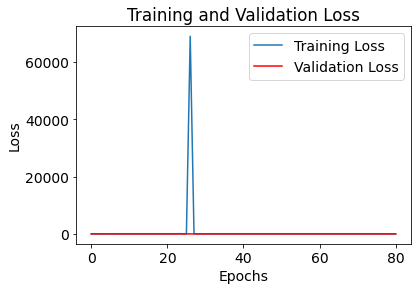

In [91]:
model_multivariate_gaussian_only_diagonal = create_model_multivariate_gaussian_only_diagonal(d, (X_train_mult.shape[1],), MODELS_SEED)
history = train_multivariate_model(model_multivariate_gaussian_only_diagonal, X_train_mult, y_train_mult, epochs=100, patience=10)

plt.plot(history.history['loss'][1:], label='Training Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [92]:
model_multivariate_gaussian_only_diagonal.evaluate(X_test_mult, y_test_mult)

571/571 [==============================] - 2s 4ms/step - loss: 25.6279


25.627878189086914

In [93]:
y_train_mult_pred = np.array(model_multivariate_gaussian_only_diagonal(X_train_mult).mean())
y_test_mult_pred = np.array(model_multivariate_gaussian_only_diagonal(X_test_mult).mean())

y_train_mult_stddevs = np.array(model_multivariate_gaussian_only_diagonal(X_train_mult).stddev())
y_test_mult_stddevs = np.array(model_multivariate_gaussian_only_diagonal(X_test_mult).stddev())

y_train_mult_covs = np.array(model_multivariate_gaussian_only_diagonal(X_train_mult).covariance())
y_test_mult_covs = np.array(model_multivariate_gaussian_only_diagonal(X_test_mult).covariance())

evaluate_and_print_metrics(results, "Non-Bayesian Multivariate (Only Diagonal)",
                           y_train_mult.ravel(), y_test_mult.ravel(),
                           y_train_mult_pred.ravel(), y_test_mult_pred.ravel(),
                           y_train_mult_stddevs.ravel(), y_test_mult_stddevs.ravel(),
                           CONFIDENCE_INTERVAL)

Train RMSE: 30.452
Test RMSE: 32.843
Train MAE: 18.816
Test MAE: 20.218
Percentage of Train Data Points within 99.00% CI: 99.12%
Percentage of Test Data Points within 99.00% CI: 98.52%


In [94]:
for i in range(y_test_mult_pred.shape[1]):
    err = mean_squared_error(y_test_mult[:, i], y_test_mult_pred[:, i])
    print(f"Turbine #{i+1} - RMSE: {sqrt(err)}")

Turbine #1 - RMSE: 32.38419674553385
Turbine #2 - RMSE: 31.828291937436564
Turbine #3 - RMSE: 34.403830040694636
Turbine #4 - RMSE: 32.2679400163782
Turbine #5 - RMSE: 32.73666297074313
Turbine #6 - RMSE: 33.37343964362443


Turbine #1:


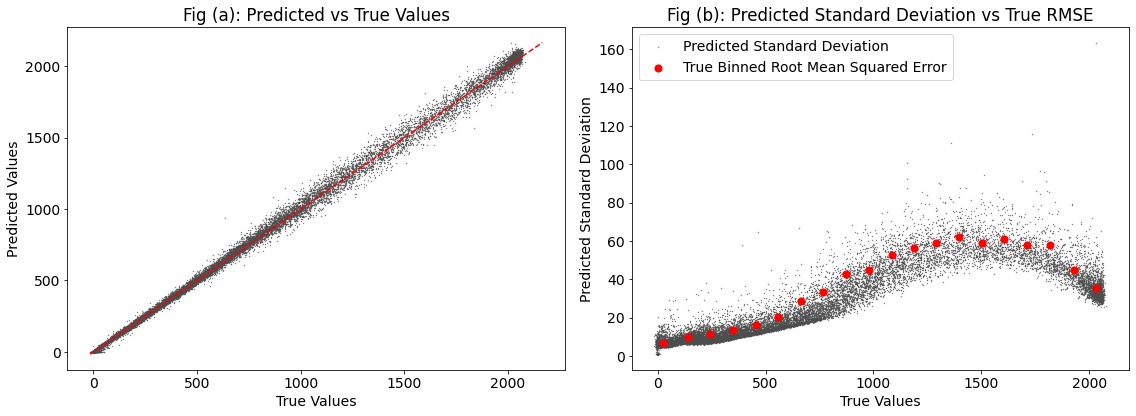

Turbine #2:


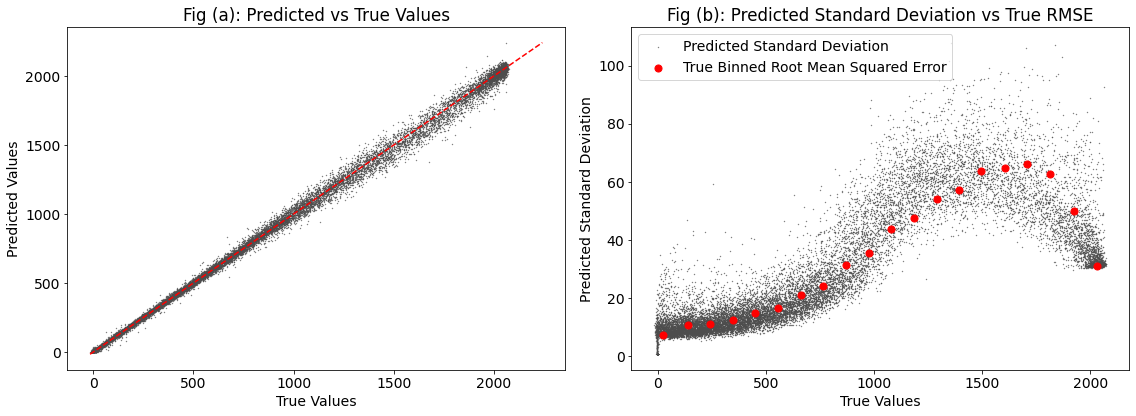

Turbine #3:


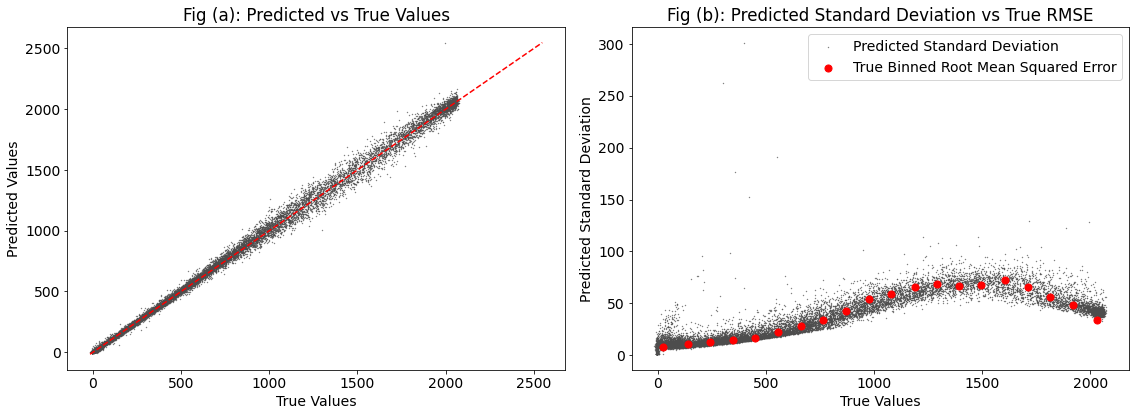

Turbine #4:


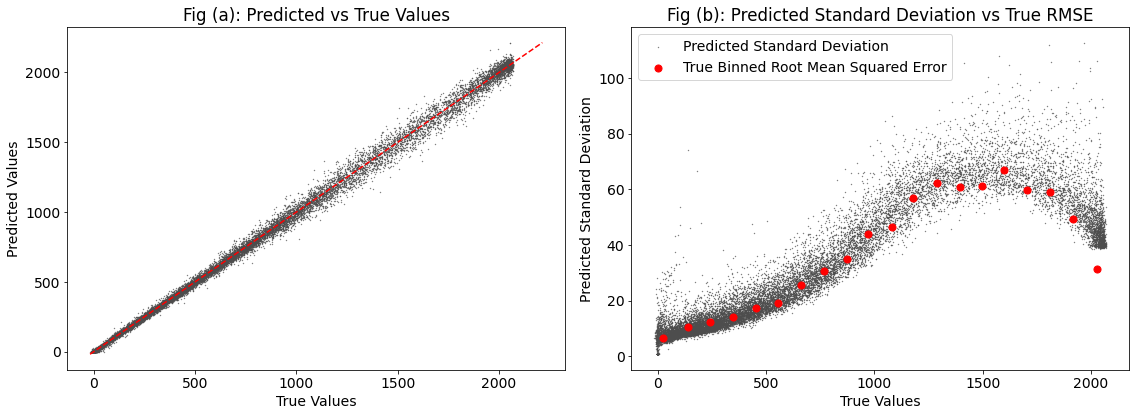

Turbine #5:


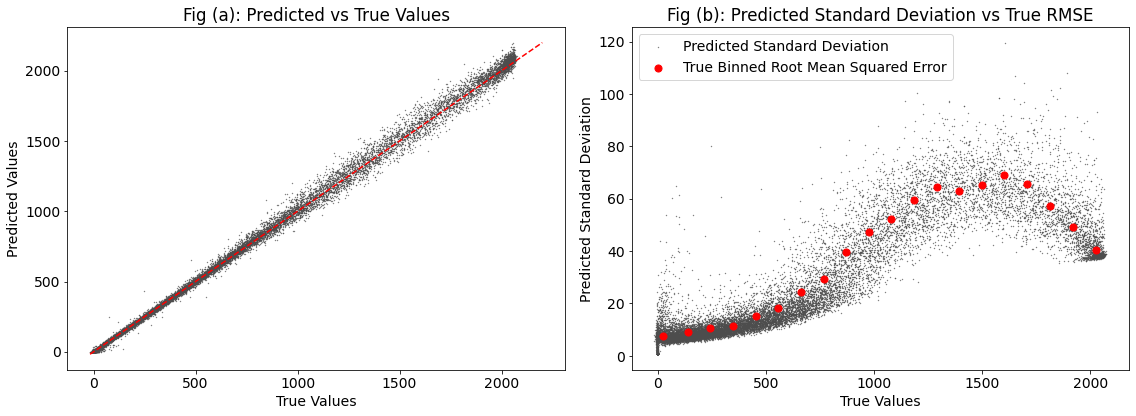

Turbine #6:


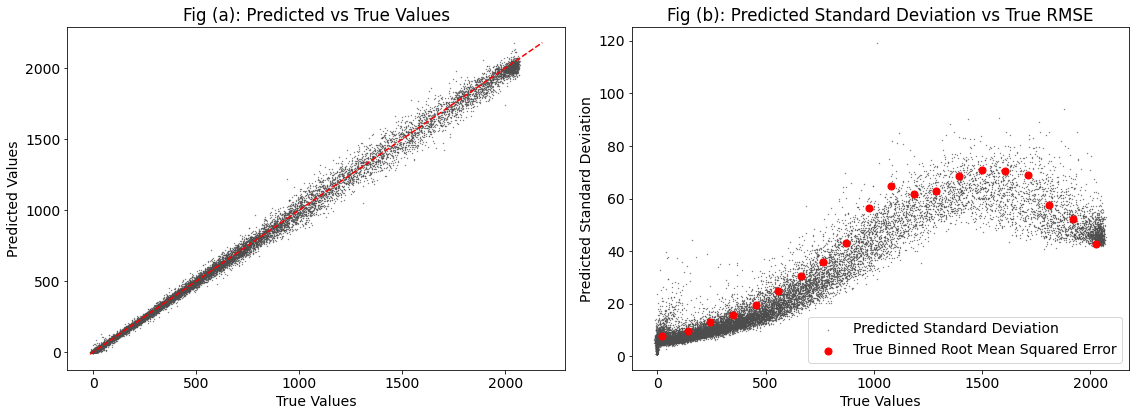

In [95]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:") 
    plot_means_variances(y_test_mult[:, i], y_test_mult_pred[:, i], y_test_mult_stddevs[:, i])

Turbine #1:


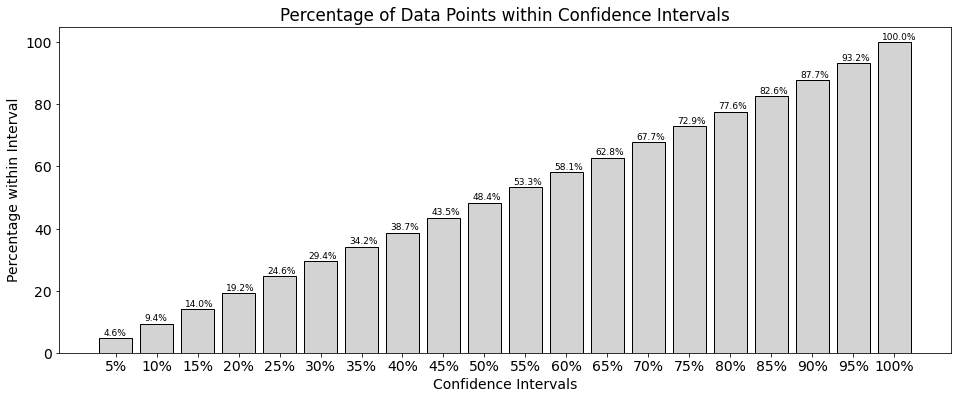

Turbine #2:


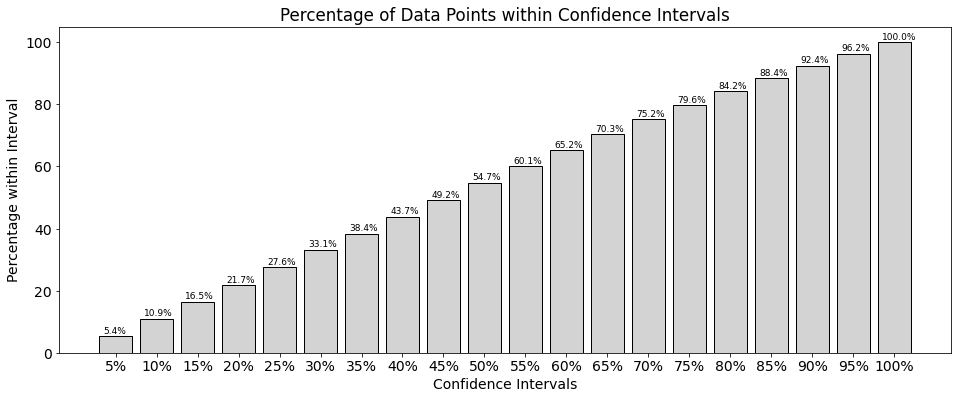

Turbine #3:


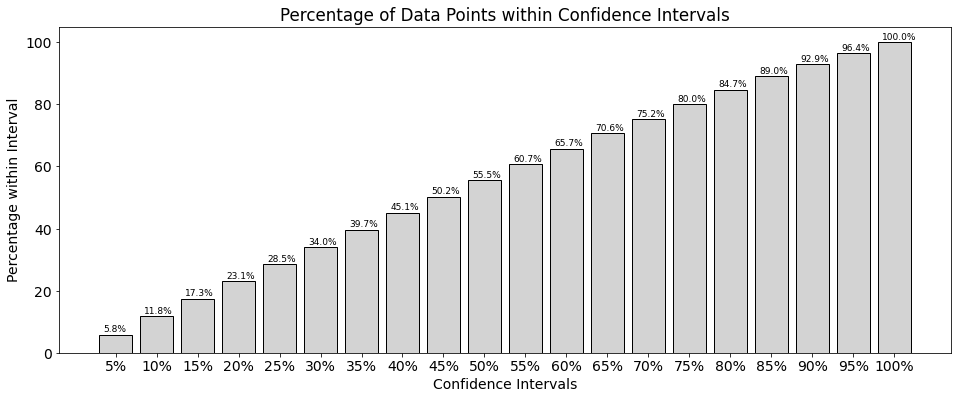

Turbine #4:


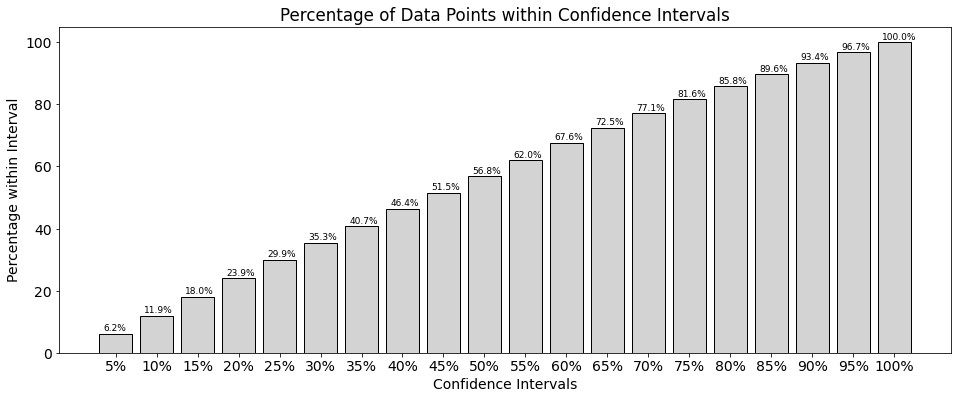

Turbine #5:


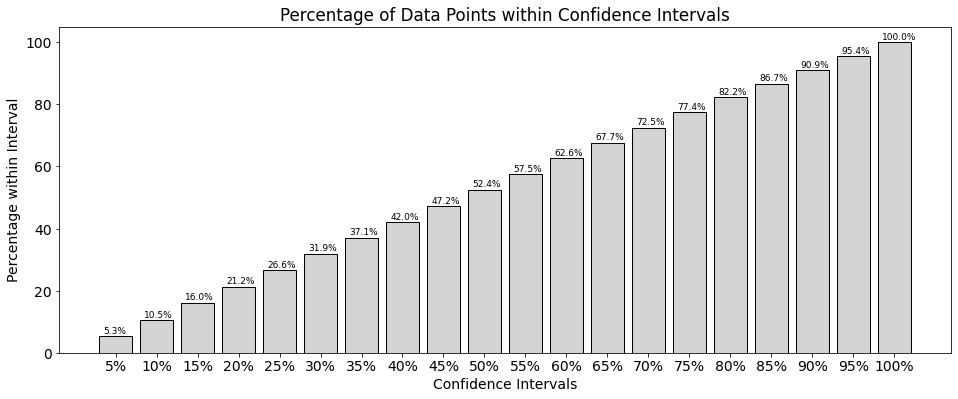

Turbine #6:


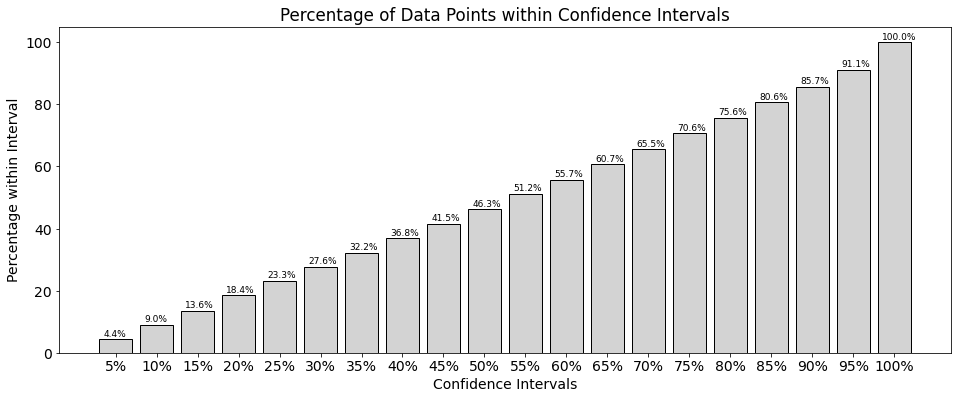

In [96]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:")
    plot_confidence_interval_histogram(y_test_mult_pred[:, i], y_test_mult_stddevs[:, i], y_test_mult[:, i], bins=20)

#### Lower Triangular Cholesky Decomposed Covariance Matrix

In the model presented below we model the full covariance matrix of a gaussian distribution. In the world of real numbers, covariance matrices are symmetric and positive-definite. To enforce this we only parametrize a lower triangular matrix as part the Cholesky decomposition of the final full covariance matrix. Therefore, for $d$ turbines, we need $d$ output units for the predicted mean vector and $d(d-1)/2$ for the predicted covariance. So $d(d+1)/2$ in total.

In [97]:
def create_model_multivariate_gaussian_with_covariance(d, input_size, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=input_size)
    
    means_final_layers = []
    covs_final_layers = []

    for i in range(d):
        n_features = inputs.shape[1]//d
        
        h_means1 = Dense(50, activation='relu')(inputs)
        h_cov1 = Dense(50, activation='relu')(inputs)
    
        h_means2 = Dense(30, activation='relu')(h_means1)
        h_cov2 = Dense(30, activation='relu')(h_cov1)
    
        h_means3 = Dense(20, activation='relu')(h_means2)
        h_cov3 = Dense(20, activation='relu')(h_cov2)
        
        means_final_layers.append(h_means3)
        covs_final_layers.append(h_cov3)
        
    concatenated_h_means1 = Concatenate()(means_final_layers)
    concatenated_h_covs1 = Concatenate()(covs_final_layers)
    
    concatenated_h_means2 = Dense(20, activation='relu')(concatenated_h_means1)
    concatenated_h_covs2 = Dense(20, activation='relu')(concatenated_h_covs1)
    
    out_mean = Dense(d, activation='linear')(concatenated_h_means2)
    out_cov = Dense(tfp.layers.MultivariateNormalTriL.params_size(d) - d)(concatenated_h_covs2)
    
    # Concatenate mean and lower triangular part of the covariance matrix
    concatenated_outputs = Concatenate()([out_mean, out_cov])
    
    # Define the distribution layer
    distribution_layer = tfp.layers.DistributionLambda(
        lambda t: multivariate_covariance_normal_softplus(t[:, :d], t[:, d:], d)
    )
    
    model = Model(inputs=inputs, outputs=distribution_layer(concatenated_outputs),
                  name="multivariate_gaussian_with_covariance")
    
    model.compile(Adam(learning_rate=0.01),
                  loss=NLL)
   
    return model

Model: "multivariate_gaussian_with_covariance"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 210)]                0         []                            
                                                                                                  
 dense_87 (Dense)            (None, 50)                   10550     ['input_11[0][0]']            
                                                                                                  
 dense_93 (Dense)            (None, 50)                   10550     ['input_11[0][0]']            
                                                                                                  
 dense_99 (Dense)            (None, 50)                   10550     ['input_11[0][0]']            
                                                              

                                                                                                  
 concatenate_13 (Concatenat  (None, 120)                  0         ['dense_92[0][0]',            
 e)                                                                  'dense_98[0][0]',            
                                                                     'dense_104[0][0]',           
                                                                     'dense_110[0][0]',           
                                                                     'dense_116[0][0]',           
                                                                     'dense_122[0][0]']           
                                                                                                  
 dense_123 (Dense)           (None, 20)                   2420      ['concatenate_12[0][0]']      
                                                                                                  
 dense_124

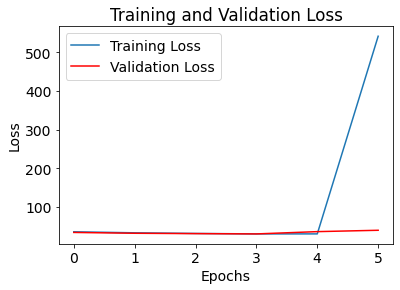

In [98]:
model_multivariate_gaussian_with_covariance = create_model_multivariate_gaussian_with_covariance(d, (X_train_mult.shape[1],), MODELS_SEED)
history = train_multivariate_model(model_multivariate_gaussian_with_covariance, X_train_mult, y_train_mult, epochs=100, patience=10)

plt.plot(history.history['loss'][1:], label='Training Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [99]:
model_multivariate_gaussian_with_covariance.evaluate(X_test_mult, y_test_mult)

571/571 [==============================] - 3s 4ms/step - loss: 30.2382


30.2381534576416

In [100]:
y_train_mult_pred = np.array(model_multivariate_gaussian_with_covariance(X_train_mult).mean())
y_test_mult_pred = np.array(model_multivariate_gaussian_with_covariance(X_test_mult).mean())

y_train_mult_stddevs = np.array(model_multivariate_gaussian_with_covariance(X_train_mult).stddev())
y_test_mult_stddevs = np.array(model_multivariate_gaussian_with_covariance(X_test_mult).stddev())

y_train_mult_covs = np.array(model_multivariate_gaussian_with_covariance(X_train_mult).covariance())
y_test_mult_covs = np.array(model_multivariate_gaussian_with_covariance(X_test_mult).covariance())

evaluate_and_print_metrics(results, "Non-Bayesian Multivariate (Lower Triangular Covariance Matrix)",
                           y_train_mult.ravel(), y_test_mult.ravel(),
                           y_train_mult_pred.ravel(), y_test_mult_pred.ravel(),
                           y_train_mult_stddevs.ravel(), y_test_mult_stddevs.ravel(),
                           CONFIDENCE_INTERVAL)

Train RMSE: 60.636
Test RMSE: 61.290
Train MAE: 40.516
Test MAE: 41.065
Percentage of Train Data Points within 99.00% CI: 98.28%
Percentage of Test Data Points within 99.00% CI: 98.20%


In [101]:
for i in range(y_test_mult_pred.shape[1]):
    err = mean_squared_error(y_test_mult[:, i], y_test_mult_pred[:, i])
    print("turbine #", i+1, "- RMSE:", sqrt(err))

turbine # 1 - RMSE: 67.82116789814447
turbine # 2 - RMSE: 54.70248169136538
turbine # 3 - RMSE: 54.236163326911104
turbine # 4 - RMSE: 69.2179825538449
turbine # 5 - RMSE: 58.093808203148406
turbine # 6 - RMSE: 61.959589145152144


Turbine #1:


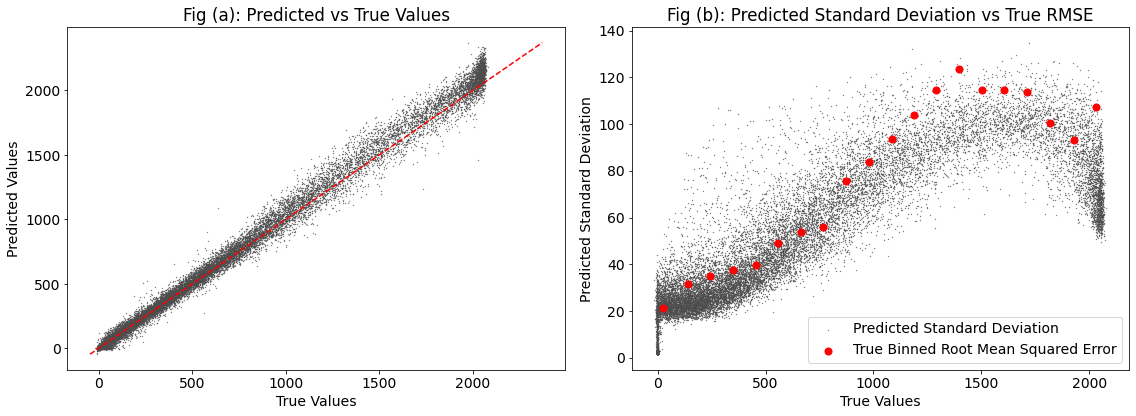

Turbine #2:


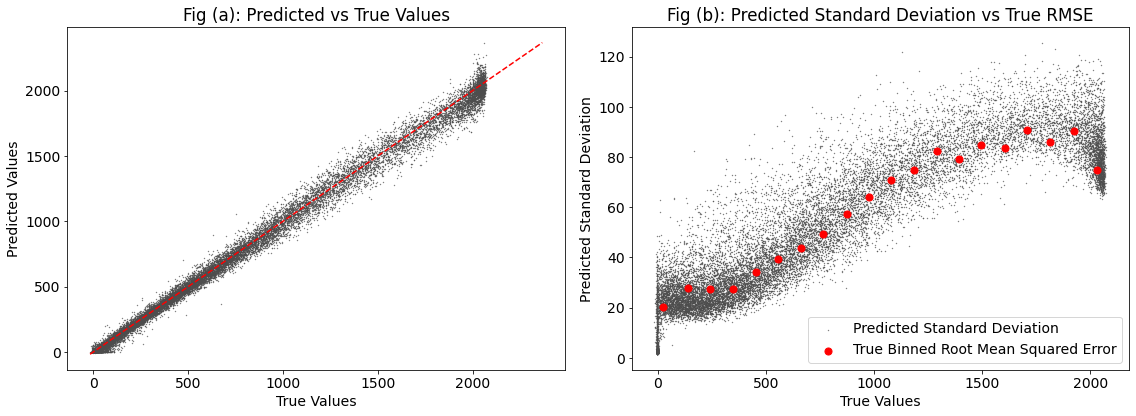

Turbine #3:


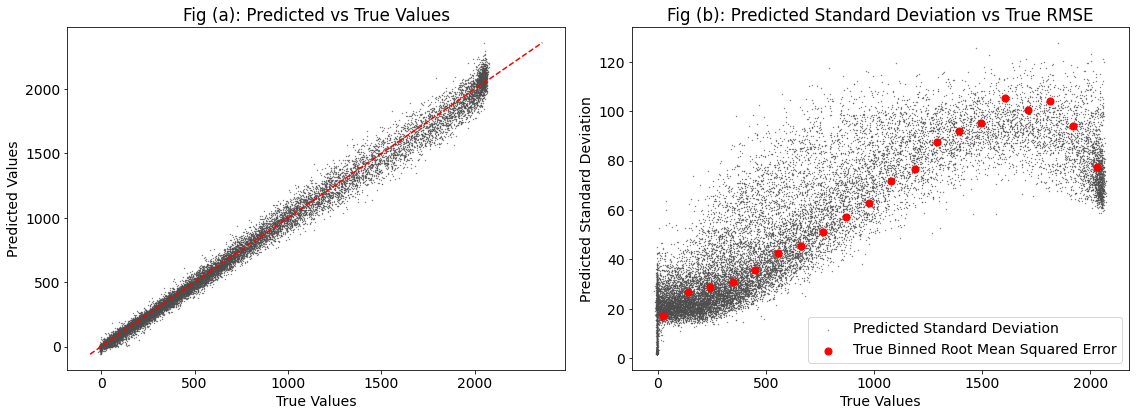

Turbine #4:


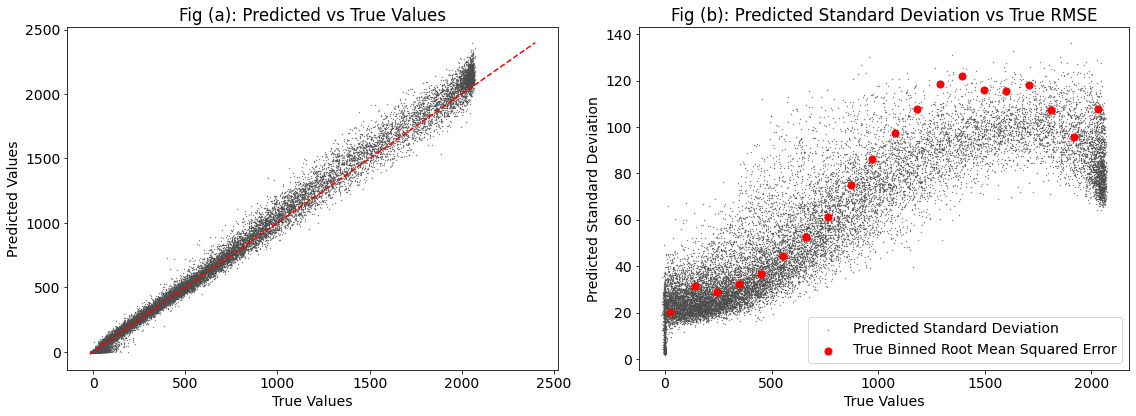

Turbine #5:


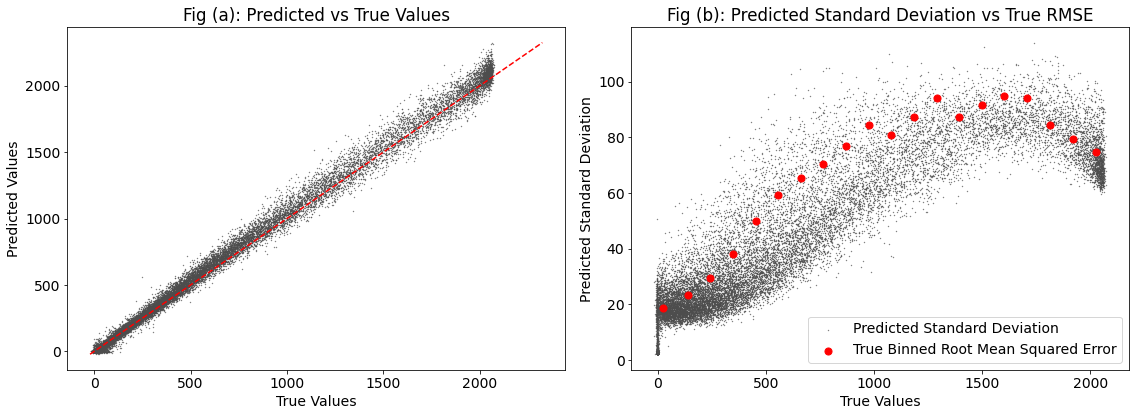

Turbine #6:


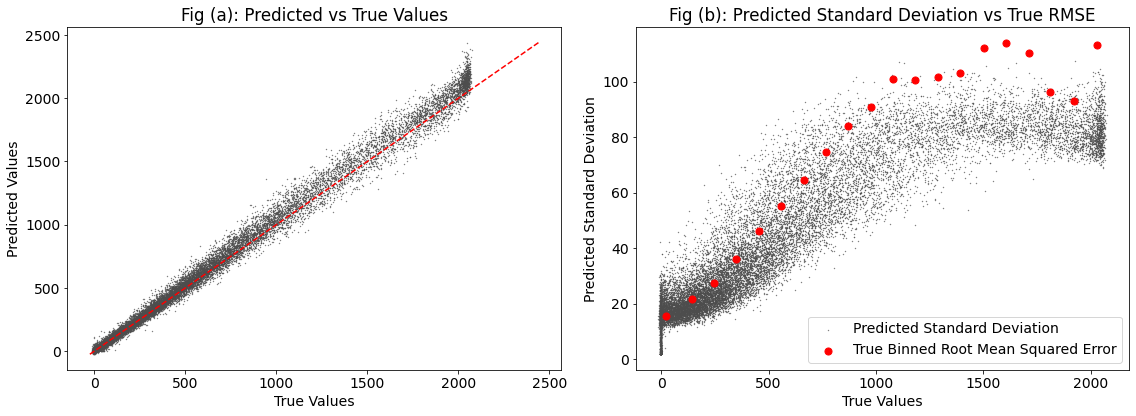

In [102]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:") 
    plot_means_variances(y_test_mult[:, i], y_test_mult_pred[:, i], y_test_mult_stddevs[:, i])

Turbine #1:


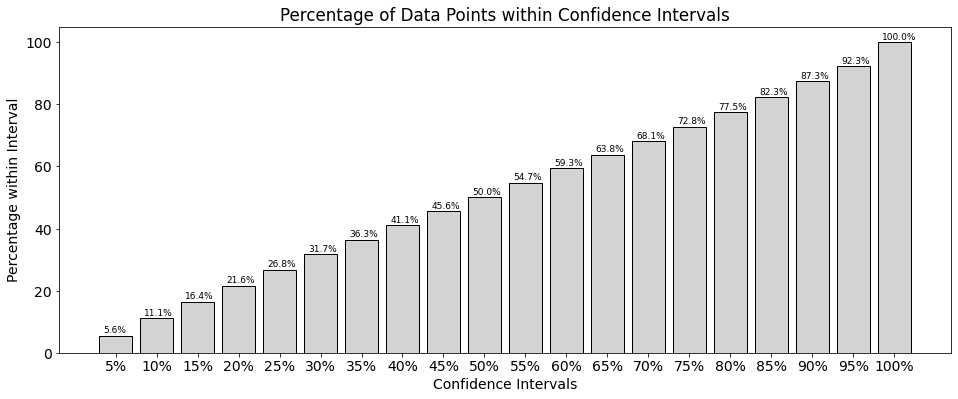

Turbine #2:


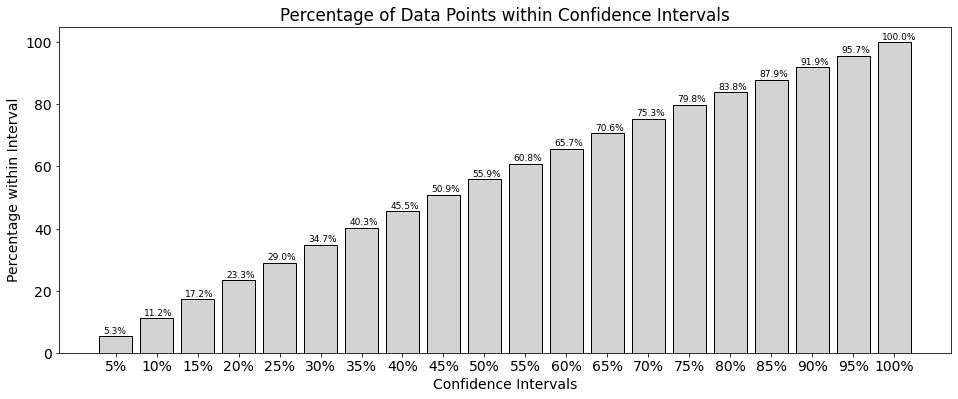

Turbine #3:


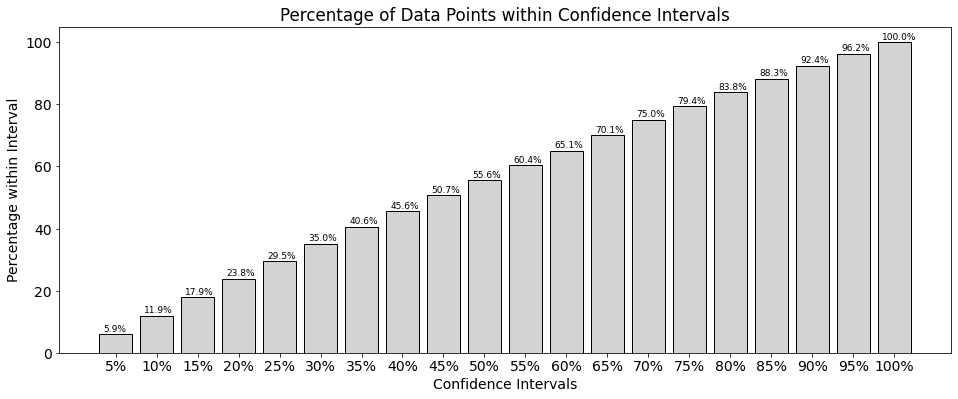

Turbine #4:


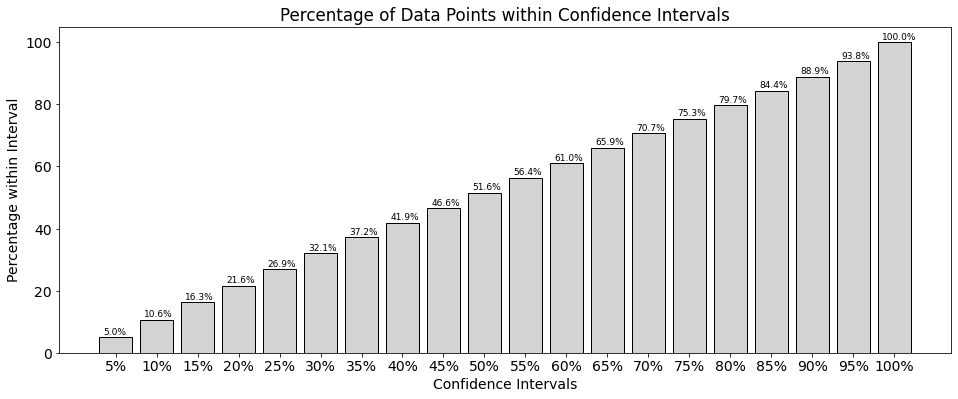

Turbine #5:


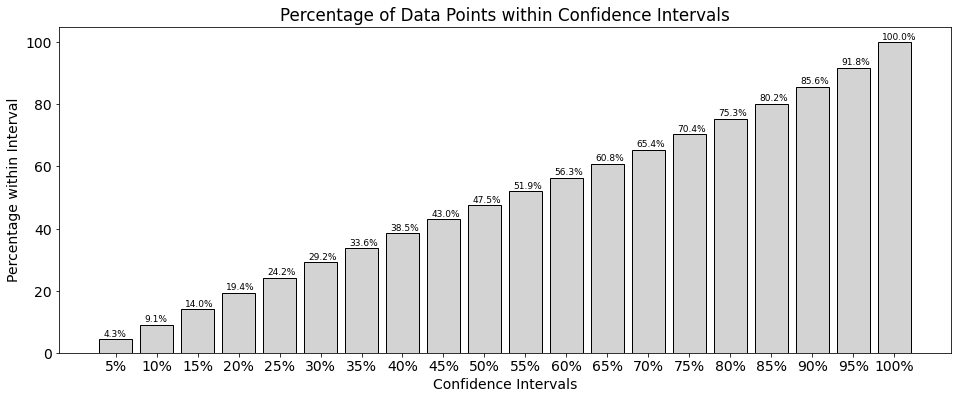

Turbine #6:


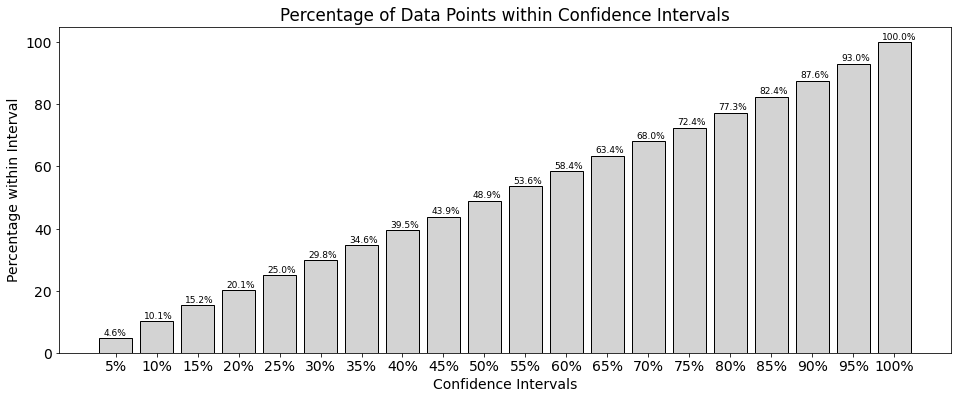

In [103]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:")
    plot_confidence_interval_histogram(y_test_mult_pred[:, i], y_test_mult_stddevs[:, i], y_test_mult[:, i], bins=20)

While we acknowledge that these multivariate models do not perform as accurately as its univariate counterparts, the exploration of this multivariate study leads to believe that, with larger data sets and greater computational resources, larger probabilistic networks could be trained to perform a probabilistic deep learning multivariate normal behaviour modelling of the power output of entire wind farms. This is something that, to the author's knowledge, has never been achieved before. In particular the limited data set of 73k data points for a very large number of tunable parameters, for example more than 150k in the network modelling covariance, does not allow for sufficiently reduced predictive variance, quantified in the amount of variation of the target function when considering a different dataset, of the network given its large capacity. 

## Results

In [104]:
# Print metric results for all trained models
for model_name, res in results.items():
    print("Model: ", model_name)
    for metric, value in res.items():
        print(f"{metric:50} {value}")
    print("\n")

Model:  Non-probabilistic MLP
Test Root Mean Squared Error (RME):                43.9999312449737
Test Mean Absolute Error (MAE):                    29.11669432950502
Percentage of Test Data Points within 0.99% CI:    96.84505108641129


Model:  Epistemic Uncertainty BNN (Flipout) - 1.0% Sample
Test Root Mean Squared Error (RME):                72.63766826834464
Test Mean Absolute Error (MAE):                    48.25426070602109
Percentage of Test Data Points within 0.99% CI:    34.28201811125485


Model:  Epistemic Uncertainty BNN (Flipout)
Test Root Mean Squared Error (RME):                886.849204993605
Test Mean Absolute Error (MAE):                    623.3871120405754
Percentage of Test Data Points within 0.99% CI:    0.007920373841645326


Model:  Aleatoric & Epistemic Uncertainty BNN (Flipout)
Test Root Mean Squared Error (RME):                27.12519821156833
Test Mean Absolute Error (MAE):                    14.780195856636471
Percentage of Test Data Points within 0.99% C